In [185]:
import pandas as pd
import seaborn as sns
import duckdb
import utils 
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import matplotlib.pyplot as plt
# The 'LinearRegression' model is initialized and fitted to the training data.
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm




In [186]:
con = duckdb.connect("data.db")


In [187]:
oecd = con.sql("SELECT * FROM oecd").df() 
ecb = con.sql("SELECT * FROM ecb").df()         # Pandas DataFrame
eurostat = con.sql("SELECT * FROM eurostat").df()         # Pandas DataFrame
world_b = con.sql("SELECT * FROM world_bank").df()         # Pandas DataFrame


In [188]:
oecd.dtypes

DATE      object
GEO       object
LTIR     float64
STIR     float64
IIR      float64
CBAR     float64
UEMPR    float64
dtype: object

# **DATA PREPARATION**

- There is two different country abbrevation thorugh the data. In this section that is fixed to three letter abrevation and 
- the data merged via abbrevations and date 
- analyzed missing values and france selected as main data becasue it has the most non-null values

## Filtering

In [189]:
import pycountry

def convert_alpha2_to_alpha3(code):
    if not code or not isinstance(code, str):
        return code
    try:
        return pycountry.countries.get(alpha_2=code.upper()).alpha_3
    except:
        return code  # return original value if not ISO

    
eurostat['GEO'] = eurostat['GEO'].apply(convert_alpha2_to_alpha3)
eurostat['GEO'].unique()


array(['BRA', 'CAN', 'CHN', 'DEU', 'FRA', 'IDN', 'IND', 'ITA', 'JPN',
       'KOR', 'MEX', 'RUS', 'USA', 'ZAF', 'ARG', 'FIN', 'SAU', 'G20',
       'TUR', 'UK', 'BEL', 'EST', 'LTU', 'EA19', 'EU28', 'EU27_2020',
       'AUT', 'BGR', 'CHE', 'CYP', 'CZE', 'DNK', 'EA20', 'EL', 'ESP',
       'HRV', 'HUN', 'IRL', 'LUX', 'LVA', 'MNE', 'MLT', 'NLD', 'NOR',
       'POL', 'PRT', 'ROU', 'SRB', 'SVN', 'SVK', 'ALB', 'BIH', 'MKD',
       'SWE'], dtype=object)

In [190]:
import pandas as pd

def compare_columns(df1, df2, column_name):
    """
    Compare columns between two DataFrames and print common and uncommon columns.

    Parameters:
    - df1, df2: pandas DataFrames to compare
    """
    cols1 = set(df1[column_name])
    cols2 = set(df2[column_name])

    common = cols1 & cols2
    only_in_df1 = cols1 - cols2
    only_in_df2 = cols2 - cols1

    print("✅ Common columns:")
    print(sorted(common))
    print("\n🟥 Only in first DataFrame:")
    print(sorted(only_in_df1))
    print("\n🟦 Only in second DataFrame:")
    print(sorted(only_in_df2))

    return {
        "common": common,
        "only_in_df1": only_in_df1,
        "only_in_df2": only_in_df2
    }


In [191]:
col_names = compare_columns(oecd,eurostat,"GEO")

✅ Common columns:
['AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHN', 'CZE', 'DEU', 'DNK', 'EA19', 'EA20', 'ESP', 'EST', 'EU27_2020', 'FIN', 'FRA', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF']

🟥 Only in first DataFrame:
['A5M', 'AUS', 'CHL', 'COL', 'CRI', 'G7', 'GBR', 'GRC', 'ISL', 'ISR', 'NZL', 'OECD', 'OECDE', 'OECDXEA']

🟦 Only in second DataFrame:
['ALB', 'ARG', 'BIH', 'CYP', 'EL', 'EU28', 'G20', 'MKD', 'MLT', 'MNE', 'SAU', 'SRB', 'UK']


In [192]:
def filter_geo(df, geo):
    """
    Filters a DataFrame by one or more GEO codes.

    Parameters:
    - df: pandas DataFrame
    - geo: a single GEO string or a list of GEO strings

    Returns:
    - Filtered DataFrame
    """
    if isinstance(geo, (list, tuple, set)):
        return df[df["GEO"].isin(geo)]
    else:
        return df[df["GEO"] == geo]


In [193]:
import pandas as pd

def null_counts_by_category(df, category_col, date_col='DATE'):
    """
    Calculates number of nulls and percentage of nulls in each column,
    grouped by values in a category column.

    Parameters:
    - df: pandas DataFrame
    - category_col: column name to group by (as string)
    - date_col: column used to count total entries per category (default='DATE')

    Returns:
    - DataFrame: index = category values, columns = original columns (with count and percentage),
                 plus 'avg_perct' column, sorted by 'avg_perct'.
    """
    if category_col not in df.columns:
        raise ValueError(f"Column '{category_col}' not found in DataFrame.")

    # Count unique occurrences for each category (denominator for %)
    total_counts = df.groupby(category_col)[date_col].nunique()

    # Count nulls
    null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())
    null_counts = null_counts.drop(columns=[category_col], errors="ignore")

    # Calculate percentage of nulls for each column
    percentage_nulls = null_counts.div(total_counts, axis=0) * 100
    percentage_nulls = percentage_nulls.round(2).astype(str) + '%'

    # Calculate average percentage per row (as float)
    avg_perct = null_counts.div(total_counts, axis=0).mean(axis=1) * 100

    # Combine counts and percentages with avg_perct
    result = pd.concat([null_counts, percentage_nulls.add_suffix('_%')], axis=1)
    result['avg_perct'] = avg_perct.round(2)

    # Sort by average percentage
    result = result.sort_values(by='avg_perct')

    return result

In [194]:
null_counts_by_category(filter_geo(oecd,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


DATE  LTIR  STIR  IIR  CBAR  UEMPR DATE_%  LTIR_%  STIR_%   IIR_%  \
GEO                                                                            
LTU           0    33     9    9    38      1   0.0%  10.22%   2.79%   2.79%   
CZE           0    87     0    0    25      1   0.0%  22.54%    0.0%    0.0%   
USA           0     0   135   15    82     21   0.0%    0.0%  15.64%   1.74%   
SVK           0    58     5    0    42     27   0.0%  16.48%   1.42%    0.0%   
FIN           0    13     0  144    11     13   0.0%   2.84%    0.0%  31.44%   
HUN           0    97    28   12    26     61   0.0%  23.66%   6.83%   2.93%   
KOR           0   129    12   12   108      0   0.0%  30.57%   2.84%   2.84%   
CAN           0     0    12  240   301      0   0.0%    0.0%   1.43%   28.5%   
ESP           0    79    43    0   158    155   0.0%  12.72%   6.92%    0.0%   
SVN           0    74    72   96     3      1   0.0%  21.14%  20.57%  27.43%   
LVA           0    95    59   59     0     63   0.0%  24.68%  15.32%  15.32%   
PRT           0   126    34  192    42      1   0.0%   24.9%   6.72%  37.94%   
DEU           0     0    44   44   201    417   0.0%    0.0%   5.33%   5.33%   
POL           0   133    18    0   138     86   0.0%  31.44%   4.26%    0.0%   
FRA           0    60   180    0   217    337   0.0%   7.13%  21.38%    0.0%   
IRL           0     0   157  337    63    146   0.0%    0.0%  24.12%  51.77%   
DNK           0   155   155  275     0    108   0.0%  25.29%  25.29%  44.86%   
ITA           0   217    68  311     0    120   0.0%  34.72%  10.88%  49.76%   
AUT           0   155   148  263     0    192   0.0%  26.86%  25.65%  45.58%   
BEL           0     0    34  528   217    337   0.0%    0.0%   4.04%  62.71%   
NOR           0    72     0   36   554    121   0.0%   13.0%    0.0%    6.5%   
LUX           0   129   192  192   229      1   0.0%  25.49%  37.94%  37.94%   
NLD           0     0   276  480   169    289   0.0%    0.0%  34.76%  60.45%   
EST           0   331    38  176     0     51   0.0%  85.31%   9.79%  45.36%   
ZAF           0     0   287    0   308    818   0.0%    0.0%  35.09%    0.0%   
RUS           0   124    59    0    79    358   0.0%  34.64%  16.48%    0.0%   
BGR           0   102   116    1   368     67   0.0%  27.72%  31.52%   0.27%   
MEX           0   374   257    0   310    138   0.0%  62.86%  43.19%    0.0%   
SWE           0   383   325   52   490    337   0.0%  45.49%   38.6%   6.18%   
CHN           0   287    89    1     1    420   0.0%  68.33%  21.19%   0.24%   
HRV           0   156   117    0   387     86   0.0%  40.31%  30.23%    0.0%   
JPN           0   408   568  366   329      1   0.0%  48.46%  67.46%  43.47%   
BRA           0     5   368   27     0    368   0.0%   1.36%  100.0%   7.34%   
CHE           0     0   534  204   215    842   0.0%    0.0%  63.42%  24.23%   
IDN           0   266    96    0   137    422   0.0%  63.03%  22.75%    0.0%   
ROU           0   116     0   42   355    355   0.0%  32.68%    0.0%  11.83%   
EA19          0     0   288  288   662    662   0.0%    0.0%   43.5%   43.5%   
TUR           0   466   466   10   213    225   0.0%  100.0%  100.0%   2.15%   
IND           0   528   528    1   537    687   0.0%  76.86%  76.86%   0.15%   
EU27_2020     0   301   301  301   301      0   0.0%  100.0%  100.0%  100.0%   
EA20          0   415   415  415   415      0   0.0%  100.0%  100.0%  100.0%   

           CBAR_% UEMPR_%  avg_perct  
GEO                                   
LTU        11.76%   0.31%       4.64  
CZE         6.48%   0.26%       4.88  
USA          9.5%   2.43%       4.89  
SVK        11.93%   7.67%       6.25  
FIN          2.4%   2.84%       6.59  
HUN         6.34%  14.88%       9.11  
KOR        25.59%    0.0%      10.31  
CAN        35.75%    0.0%      10.95  
ESP        25.44%  24.96%      11.67  
SVN         0.86%   0.29%      11.71  
LVA          0.0%  16.36%      11.95  
PRT          8.3%    0.2%      13.01  
DEU        24.33%  50.48

In [195]:
null_counts_by_category(filter_geo(eurostat,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


DATE  Retail_Volume  CPI DATE_% Retail_Volume_%   CPI_%  avg_perct
GEO                                                                          
DEU           0              2    0   0.0%           0.53%    0.0%       0.18
EU27_2020     0              2    0   0.0%           0.66%    0.0%       0.22
FRA           0             62    0   0.0%          16.58%    0.0%       5.53
ITA           0             74    0   0.0%          19.79%    0.0%       6.60
TUR           0            168    0   0.0%          48.28%    0.0%      16.09
KOR           0            374    0   0.0%          100.0%    0.0%      33.33
LTU           0              0  324   0.0%            0.0%  100.0%      33.33
LUX           0              0  300   0.0%            0.0%  100.0%      33.33
LVA           0              0  300   0.0%            0.0%  100.0%      33.33
MEX           0            367    0   0.0%          100.0%    0.0%      33.33
NLD           0              0  300   0.0%            0.0%  100.0%      33.33
AUT           0              0  300   0.0%            0.0%  100.0%      33.33
POL           0              0  300   0.0%            0.0%  100.0%      33.33
PRT           0              0  300   0.0%            0.0%  100.0%      33.33
ROU           0              0  300   0.0%            0.0%  100.0%      33.33
RUS           0            340    0   0.0%          100.0%    0.0%      33.33
SVK           0              0  300   0.0%            0.0%  100.0%      33.33
SVN           0              0  300   0.0%            0.0%  100.0%      33.33
SWE           0              0   24   0.0%            0.0%  100.0%      33.33
JPN           0            338    0   0.0%          100.0%    0.0%      33.33
NOR           0              0  300   0.0%            0.0%  100.0%      33.33
IND           0            373    0   0.0%          100.0%    0.0%      33.33
USA           0            374    0   0.0%          100.0%    0.0%      33.33
BEL           0              0  324   0.0%            0.0%  100.0%      33.33
BGR           0              0  300   0.0%            0.0%  100.0%      33.33
BRA           0            374    0   0.0%          100.0%    0.0%      33.33
CAN           0            373    0   0.0%          100.0%    0.0%      33.33
CHE           0              0  300   0.0%            0.0%  100.0%      33.33
CHN           0            374    0   0.0%          100.0%    0.0%      33.33
CZE           0              0  300   0.0%            0.0%  100.0%      33.33
IRL           0              0  107   0.0%            0.0%  100.0%      33.33
DNK           0              0  300   0.0%            0.0%  100.0%      33.33
EA20          0              0  300   0.0%            0.0%  100.0%      33.33
ESP           0              0  300   0.0%            0.0%  100.0%      33.33
EST           0              0  324   0.0%            0.0%  100.0%      33.33
FIN           0              0  360   0.0%            0.0%  100.0%      33.33
HRV           0              0  300   0.0%            0.0%  100.0%      33.33
HUN           0              0  300   0.0%            0.0%  100.0%      33.33
IDN           0            374    0   0.0%          100.0%    0.0%      33.33
EA19          0              0  307   0.0%            0.0%  100.0%      33.33
ZAF           0            373    0   0.0%          100.0%    0.0%      33.33

In [196]:

df_merged_0 = filter_geo(eurostat,["FRA"]).merge(filter_geo(oecd,["FRA"]), on="DATE", how="outer")
df_merged_0

DATE GEO_x  Retail_Volume  CPI GEO_y  LTIR      STIR       IIR  \
0    1955-01   NaN            NaN  NaN   FRA   NaN       NaN  3.270000   
1    1955-02   NaN            NaN  NaN   FRA   NaN       NaN  3.250000   
2    1955-03   NaN            NaN  NaN   FRA   NaN       NaN  3.280000   
3    1955-04   NaN            NaN  NaN   FRA   NaN       NaN  3.230000   
4    1955-05   NaN            NaN  NaN   FRA   NaN       NaN  3.270000   
..       ...   ...            ...  ...   ...   ...       ...       ...   
837  2024-10   FRA           -0.5  0.3   FRA  2.99  3.166609  3.371394   
838  2024-11   FRA            0.2 -0.1   FRA  3.09  3.006762  3.164967   
839  2024-12   FRA           -0.7  0.2   FRA  3.01  2.816091  3.102686   
840  2025-01   FRA           -0.1 -0.2   FRA  3.32  2.703130  2.918839   
841  2025-02   FRA            NaN  0.1   FRA  3.15  2.524950  2.732345   

         CBAR  UEMPR  
0         NaN    NaN  
1         NaN    NaN  
2         NaN    NaN  
3         NaN    NaN  
4         NaN    NaN  
..        ...    ...  
837 -0.154174    7.3  
838 -0.386029    7.3  
839 -0.372024    7.3  
840  0.575679    7.3  
841  0.154698    NaN  

[842 rows x 10 columns]

In [197]:
df_merged = df_merged_0.merge(world_b, on="DATE", how="outer")
df_merged

DATE GEO_x  Retail_Volume  CPI GEO_y  LTIR      STIR       IIR  \
0    1955-01   NaN            NaN  NaN   FRA   NaN       NaN  3.270000   
1    1955-02   NaN            NaN  NaN   FRA   NaN       NaN  3.250000   
2    1955-03   NaN            NaN  NaN   FRA   NaN       NaN  3.280000   
3    1955-04   NaN            NaN  NaN   FRA   NaN       NaN  3.230000   
4    1955-05   NaN            NaN  NaN   FRA   NaN       NaN  3.270000   
..       ...   ...            ...  ...   ...   ...       ...       ...   
837  2024-10   FRA           -0.5  0.3   FRA  2.99  3.166609  3.371394   
838  2024-11   FRA            0.2 -0.1   FRA  3.09  3.006762  3.164967   
839  2024-12   FRA           -0.7  0.2   FRA  3.01  2.816091  3.102686   
840  2025-01   FRA           -0.1 -0.2   FRA  3.32  2.703130  2.918839   
841  2025-02   FRA            NaN  0.1   FRA  3.15  2.524950  2.732345   

         CBAR  UEMPR  POP_y  
0         NaN    NaN    NaN  
1         NaN    NaN    NaN  
2         NaN    NaN    NaN  
3         NaN    NaN    NaN  
4         NaN    NaN    NaN  
..        ...    ...    ...  
837 -0.154174    7.3    NaN  
838 -0.386029    7.3    NaN  
839 -0.372024    7.3    NaN  
840  0.575679    7.3    NaN  
841  0.154698    NaN    NaN  

[842 rows x 11 columns]

### Handling missing values

In [198]:
import pandas as pd

# Assume df is your DataFrame and 'date' is your date column
df = df_merged.sort_values('DATE').reset_index(drop=True)  # Make sure it's sorted by date
# Identify numeric columns (excluding date)
numeric_cols = df.select_dtypes(include='number').columns

# Create a mask where all numeric values are NaN
all_nan_mask = df[numeric_cols].isnull().any(axis=1)
# Find first and last index where not all numeric values are NaN
first_valid_idx = df[~all_nan_mask].index[0]
last_valid_idx = df[~all_nan_mask].index[-1]

# Trim DataFrame from first to last valid index
df_trimmed = df.loc[first_valid_idx:last_valid_idx].copy()

# Fill missing values between using interpolation (or any other method)
df_filled = df_trimmed.copy()
df_filled[numeric_cols] = df_trimmed[numeric_cols].interpolate(method='linear')

# Optional: fill remaining nulls if interpolation didn't cover all
df_filled[numeric_cols] = df_filled[numeric_cols].fillna(method='bfill').fillna(method='ffill')


/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/2430720086.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[numeric_cols] = df_filled[numeric_cols].fillna(method='bfill').fillna(method='ffill')


In [199]:
df_filled

DATE GEO_x  Retail_Volume  CPI GEO_y    LTIR      STIR       IIR  \
529  1999-02   FRA            1.7  0.4   FRA  3.9377  3.093400  3.118000   
530  1999-03   FRA            0.8  0.3   FRA  4.1367  3.046696  2.925200   
531  1999-04   FRA           -0.4  0.3   FRA  3.9893  2.696455  2.709100   
532  1999-05   FRA            0.7  0.0   FRA  4.1686  2.578952  2.551000   
533  1999-06   FRA            0.0  0.0   FRA  4.4893  2.626682  2.563200   
..       ...   ...            ...  ...   ...     ...       ...       ...   
811  2022-08   FRA            1.3  0.5   FRA  1.6900  0.394739 -0.094652   
812  2022-09   FRA            1.9 -0.5   FRA  2.4100  1.010864  0.254584   
813  2022-10   FRA           -1.6  1.2   FRA  2.7700  1.427667  0.655379   
814  2022-11   FRA           -1.0  0.4   FRA  2.5800  1.825227  1.266620   
815  2022-12   FRA            0.0 -0.1   FRA  2.6200  2.063476  1.503965   

         CBAR  UEMPR         POP_y  
529  0.030459   12.0  6.053671e+07  
530 -0.182699   11.8  6.057143e+07  
531 -0.091516   11.7  6.060615e+07  
532  0.030533   11.5  6.064088e+07  
533  0.137358   11.4  6.067560e+07  
..        ...    ...           ...  
811  0.454176    7.2  6.806502e+07  
812 -0.545665    7.1  6.806502e+07  
813  0.250815    7.2  6.806502e+07  
814  0.328371    7.2  6.806502e+07  
815 -0.280540    7.2  6.806502e+07  

[287 rows x 11 columns]

## Stationarity

### Stationarity Checking

In [200]:
df_filled.set_index("DATE", inplace=True)

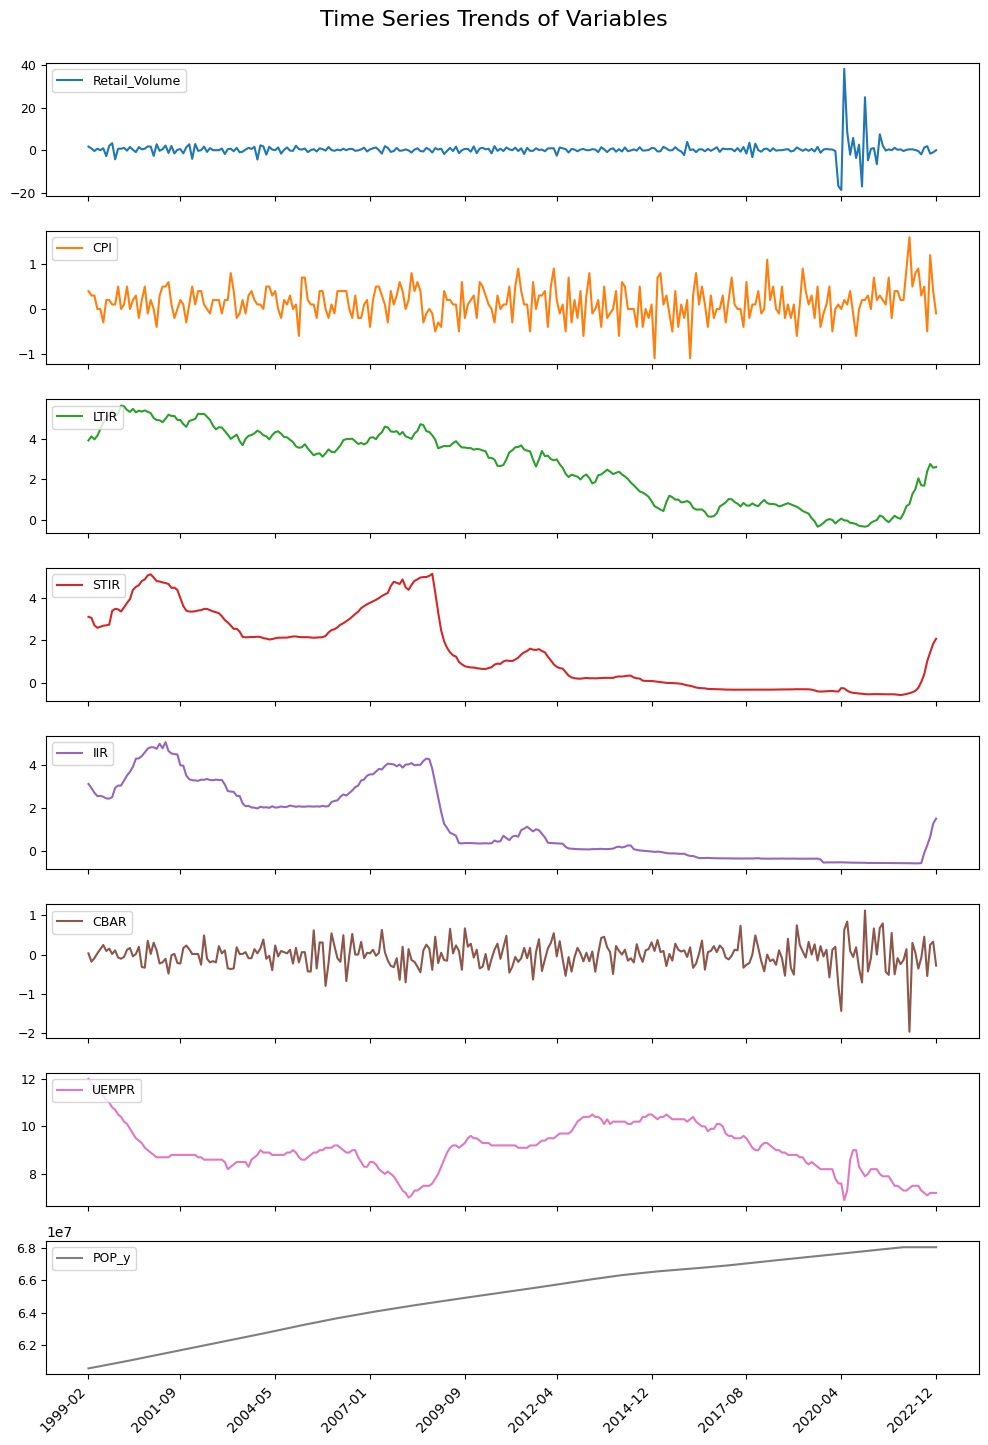

In [201]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Select numeric columns
numeric_columns = df_filled.select_dtypes(include='number').columns

# Create subplots
fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(10, 1.8 * len(numeric_columns)), sharex=True)
fig.suptitle("Time Series Trends of Variables", fontsize=16, y=1)

# Determine x-ticks
index_values = df_filled.index
tick_indices = np.linspace(0, len(index_values) - 1, 10, dtype=int)
xticks = index_values[tick_indices]

# Plot each numeric column
colors = plt.cm.tab10.colors
for i, column in enumerate(numeric_columns):
    ax = axes[i]
    ax.plot(index_values, df_filled[column], label=column, color=colors[i % len(colors)], linewidth=1.5)
    ax.legend(loc='upper left', fontsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.set_xticks(xticks)

    # Format x-ticks if index is datetime
    if pd.api.types.is_datetime64_any_dtype(index_values):
        ax.set_xticklabels([x.strftime('%Y-%m') for x in xticks], rotation=45, ha='right')
    else:
        ax.set_xticklabels(xticks, rotation=45, ha='right')

# Adjust layout
plt.subplots_adjust(top=0.94, hspace=0.4)
plt.tight_layout()
plt.show()


In [202]:
df_test = df_filled[['Retail_Volume', 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR',"POP_y"]].copy()

In [203]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import pandas as pd

def check_stationarity_extended(df, signif=0.05, regression='c'):
    """
    Check stationarity for each numeric column using multiple tests:
    ADF, KPSS, and PP.

    Parameters:
    - df: pandas DataFrame with numeric columns.
    - signif: significance level (default=0.05)
    - regression: type of regression (default='c' → constant only).
                  Options: 'c' (constant), 'ct' (constant + trend), 'nc' (no constant)

    Returns:
    - pd.DataFrame: one row per column, including test statistics, p-values, and stationarity results.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    results = []

    for col in df.select_dtypes(include='number').columns:
        row = {"Column": col}
        series = df[col].dropna()

        if len(series) < 10:
            row.update({
                "ADF_Stat": "Too short",
                "ADF_p-value": "Too short",
                "ADF_Stationary": "Too short",
                "KPSS_Stat": "Too short",
                "KPSS_p-value": "Too short",
                "KPSS_Stationary": "Too short",
                "PP_Stat": "Too short",
                "PP_p-value": "Too short",
                "PP_Stationary": "Too short"
            })
            results.append(row)
            continue

        # Augmented Dickey-Fuller
        try:
            adf_stat, adf_p, *_ = adfuller(series, regression=regression)
            row["ADF_Stat"] = round(adf_stat, 3)
            row["ADF_p-value"] = round(adf_p, 3)
            row["ADF_Stationary"] = adf_p < signif
        except Exception as e:
            row["ADF_Stat"] = f"Error: {str(e)}"
            row["ADF_p-value"] = f"Error: {str(e)}"
            row["ADF_Stationary"] = f"Error: {str(e)}"

        # KPSS (note: here null = stationary)
        try:
            kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
            row["KPSS_Stat"] = round(kpss_stat, 3)
            row["KPSS_p-value"] = round(kpss_p, 3)
            row["KPSS_Stationary"] = kpss_p > signif  # fail to reject ⇒ stationary
        except Exception as e:
            row["KPSS_Stat"] = f"Error: {str(e)}"
            row["KPSS_p-value"] = f"Error: {str(e)}"
            row["KPSS_Stationary"] = f"Error: {str(e)}"

        # Phillips-Perron
        try:
            pp_test = PhillipsPerron(series)
            row["PP_Stat"] = round(pp_test.stat, 3)
            row["PP_p-value"] = round(pp_test.pvalue, 3)
            row["PP_Stationary"] = pp_test.pvalue < signif
        except Exception as e:
            row["PP_Stat"] = f"Error: {str(e)}"
            row["PP_p-value"] = f"Error: {str(e)}"
            row["PP_Stationary"] = f"Error: {str(e)}"

        results.append(row)

    return pd.DataFrame(results)


In [204]:
check_stationarity_extended(df_test)

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/961962514.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/961962514.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/961962514.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/961962

Column  ADF_Stat  ADF_p-value  ADF_Stationary  KPSS_Stat  \
0  Retail_Volume    -8.095        0.000            True      0.150   
1            CPI    -1.701        0.431           False      0.177   
2           LTIR    -1.281        0.638           False      2.419   
3           STIR    -2.149        0.225           False      2.066   
4            IIR    -1.709        0.427           False      2.149   
5           CBAR    -5.949        0.000            True      0.025   
6          UEMPR    -2.131        0.232           False      0.305   
7          POP_y    -2.478        0.121           False      2.663   

   KPSS_p-value  KPSS_Stationary  PP_Stat  PP_p-value  PP_Stationary  
0          0.10             True  -31.846       0.000           True  
1          0.10             True  -17.171       0.000           True  
2          0.01            False   -1.182       0.681          False  
3          0.01            False   -1.675       0.444          False  
4          0.01            False   -1.647       0.459          False  
5          0.10             True  -20.035       0.000           True  
6          0.10             True   -2.678       0.078          False  
7          0.01            False   -9.828       0.000           True

- Retail_Volume: ✅ Stationary (Strong evidence)
- CPI: ⚠️ Mixed (likely trend-stationary)
- LTIR: ❌ Not stationary
- STIR: ❌ Not stationary
- IIR: ❌ Not stationary
- CBAR: ✅ Stationary (Strong evidence)
- UEMPR: ⚠️ Mixed (inconclusive)
- POP_y: ❌ Not stationary




### Transformaiton to Make Data Stationary

#### Differencing

In [205]:
df_test

Retail_Volume  CPI    LTIR      STIR       IIR      CBAR  UEMPR  \
DATE                                                                       
1999-02            1.7  0.4  3.9377  3.093400  3.118000  0.030459   12.0   
1999-03            0.8  0.3  4.1367  3.046696  2.925200 -0.182699   11.8   
1999-04           -0.4  0.3  3.9893  2.696455  2.709100 -0.091516   11.7   
1999-05            0.7  0.0  4.1686  2.578952  2.551000  0.030533   11.5   
1999-06            0.0  0.0  4.4893  2.626682  2.563200  0.137358   11.4   
...                ...  ...     ...       ...       ...       ...    ...   
2022-08            1.3  0.5  1.6900  0.394739 -0.094652  0.454176    7.2   
2022-09            1.9 -0.5  2.4100  1.010864  0.254584 -0.545665    7.1   
2022-10           -1.6  1.2  2.7700  1.427667  0.655379  0.250815    7.2   
2022-11           -1.0  0.4  2.5800  1.825227  1.266620  0.328371    7.2   
2022-12            0.0 -0.1  2.6200  2.063476  1.503965 -0.280540    7.2   

                POP_y  
DATE                   
1999-02  6.053671e+07  
1999-03  6.057143e+07  
1999-04  6.060615e+07  
1999-05  6.064088e+07  
1999-06  6.067560e+07  
...               ...  
2022-08  6.806502e+07  
2022-09  6.806502e+07  
2022-10  6.806502e+07  
2022-11  6.806502e+07  
2022-12  6.806502e+07  

[287 rows x 8 columns]

In [206]:
diff_df = df_test[['CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR',"POP_y"]].diff().dropna()[:-12]
diff_df

CPI    LTIR      STIR       IIR  UEMPR         POP_y
DATE                                                         
1999-03 -0.1  0.1990 -0.046704 -0.192800   -0.2  34722.916667
1999-04  0.0 -0.1474 -0.350241 -0.216100   -0.1  34722.916667
1999-05 -0.3  0.1793 -0.117503 -0.158100   -0.2  34722.916667
1999-06  0.0  0.3207  0.047730  0.012200   -0.1  34722.916667
1999-07 -0.3  0.3327  0.049773 -0.042300   -0.1  34722.916667
...      ...     ...       ...       ...    ...           ...
2021-08  0.6 -0.1100 -0.002773 -0.001578    0.0  18517.000000
2021-09 -0.9  0.1600  0.002545 -0.001260   -0.2  18517.000000
2021-10  0.6  0.1600 -0.004764 -0.001053   -0.2  18517.000000
2021-11  0.0 -0.1000 -0.017554 -0.002824    0.0  18517.000000
2021-12 -0.2 -0.0500 -0.014593 -0.003135   -0.1  18517.000000

[274 rows x 6 columns]

In [207]:
check_stationarity_extended(diff_df)

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/961962514.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/961962514.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/961962514.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/961962

Column  ADF_Stat  ADF_p-value  ADF_Stationary  KPSS_Stat  KPSS_p-value  \
0    CPI   -10.227        0.000            True      0.097          0.10   
1   LTIR   -11.331        0.000            True      0.128          0.10   
2   STIR    -5.024        0.000            True      0.055          0.10   
3    IIR    -4.848        0.000            True      0.048          0.10   
4  UEMPR    -4.721        0.000            True      0.307          0.10   
5  POP_y    -1.274        0.641           False      2.334          0.01   

   KPSS_Stationary  PP_Stat  PP_p-value  PP_Stationary  
0             True  -71.869       0.000           True  
1             True  -11.946       0.000           True  
2             True   -7.787       0.000           True  
3             True  -10.972       0.000           True  
4             True  -11.242       0.000           True  
5            False   -0.717       0.842          False

In [208]:
diff_df

CPI    LTIR      STIR       IIR  UEMPR         POP_y
DATE                                                         
1999-03 -0.1  0.1990 -0.046704 -0.192800   -0.2  34722.916667
1999-04  0.0 -0.1474 -0.350241 -0.216100   -0.1  34722.916667
1999-05 -0.3  0.1793 -0.117503 -0.158100   -0.2  34722.916667
1999-06  0.0  0.3207  0.047730  0.012200   -0.1  34722.916667
1999-07 -0.3  0.3327  0.049773 -0.042300   -0.1  34722.916667
...      ...     ...       ...       ...    ...           ...
2021-08  0.6 -0.1100 -0.002773 -0.001578    0.0  18517.000000
2021-09 -0.9  0.1600  0.002545 -0.001260   -0.2  18517.000000
2021-10  0.6  0.1600 -0.004764 -0.001053   -0.2  18517.000000
2021-11  0.0 -0.1000 -0.017554 -0.002824    0.0  18517.000000
2021-12 -0.2 -0.0500 -0.014593 -0.003135   -0.1  18517.000000

[274 rows x 6 columns]

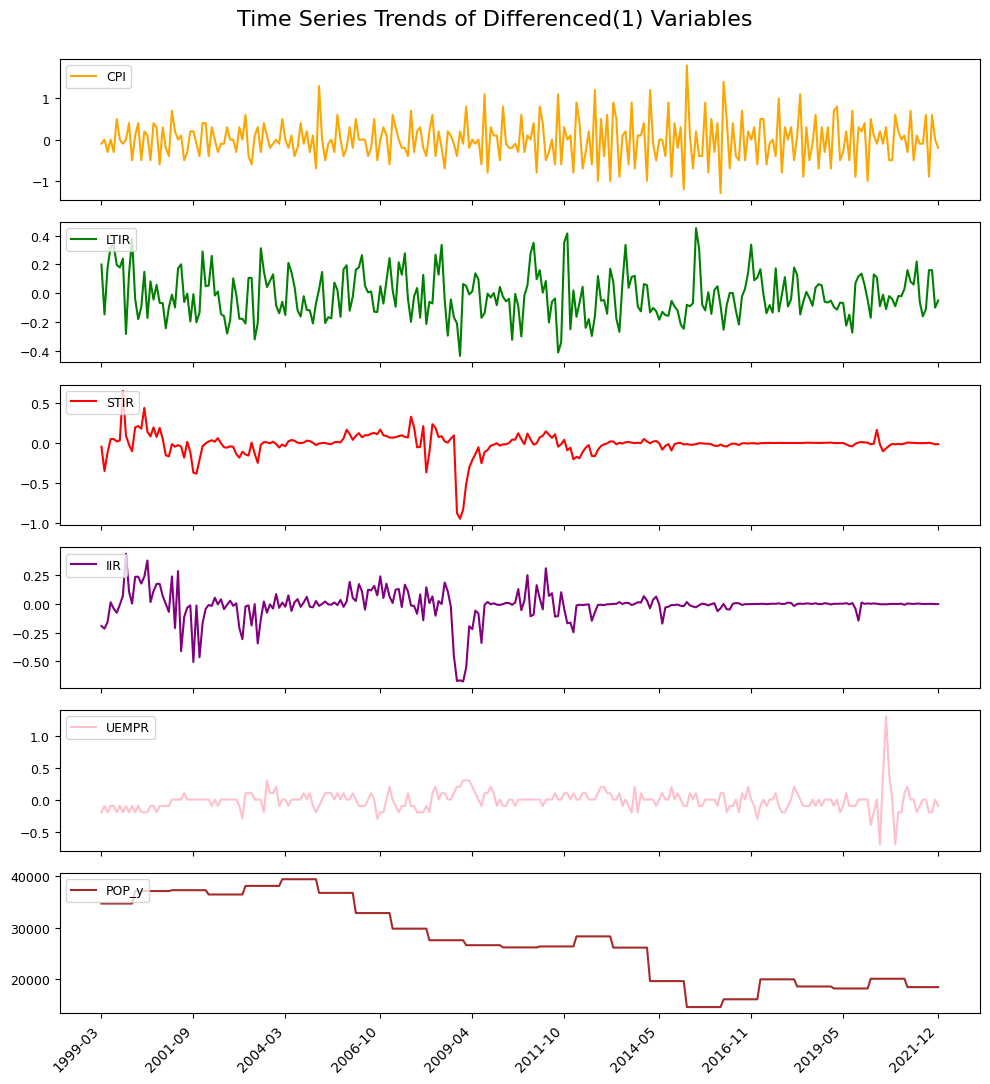

In [209]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Ensure correct column selection
numeric_columns = ['CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR', 'POP_y']
color_map = {
    'CPI': 'orange',
    'LTIR': 'green',
    'STIR': 'red',
    'IIR': 'purple',
    'UEMPR': 'pink',
    'POP_y': 'brown'
}

# Create subplots
fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(10, 1.8 * len(numeric_columns)), sharex=True)
fig.suptitle("Time Series Trends of Differenced(1) Variables", fontsize=16, y=1)

# Determine x-ticks
index_values = diff_df.index
tick_indices = np.linspace(0, len(index_values) - 1, 10, dtype=int)
xticks = index_values[tick_indices]

# Plot each numeric column using the color map
for i, column in enumerate(numeric_columns):
    ax = axes[i]
    ax.plot(index_values, diff_df[column], label=column, color=color_map[column], linewidth=1.5)
    ax.legend(loc='upper left', fontsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.set_xticks(xticks)

    # Format x-ticks if index is datetime
    if pd.api.types.is_datetime64_any_dtype(index_values):
        ax.set_xticklabels([x.strftime('%Y-%m') for x in xticks], rotation=45, ha='right')
    else:
        ax.set_xticklabels(xticks, rotation=45, ha='right')

# Layout adjustments
plt.subplots_adjust(top=0.92, hspace=0.4)
plt.tight_layout()
plt.show()


In [210]:
df_stationary = df_test[["Retail_Volume", "CBAR"]].merge(diff_df, left_index=True, right_index=True).dropna()

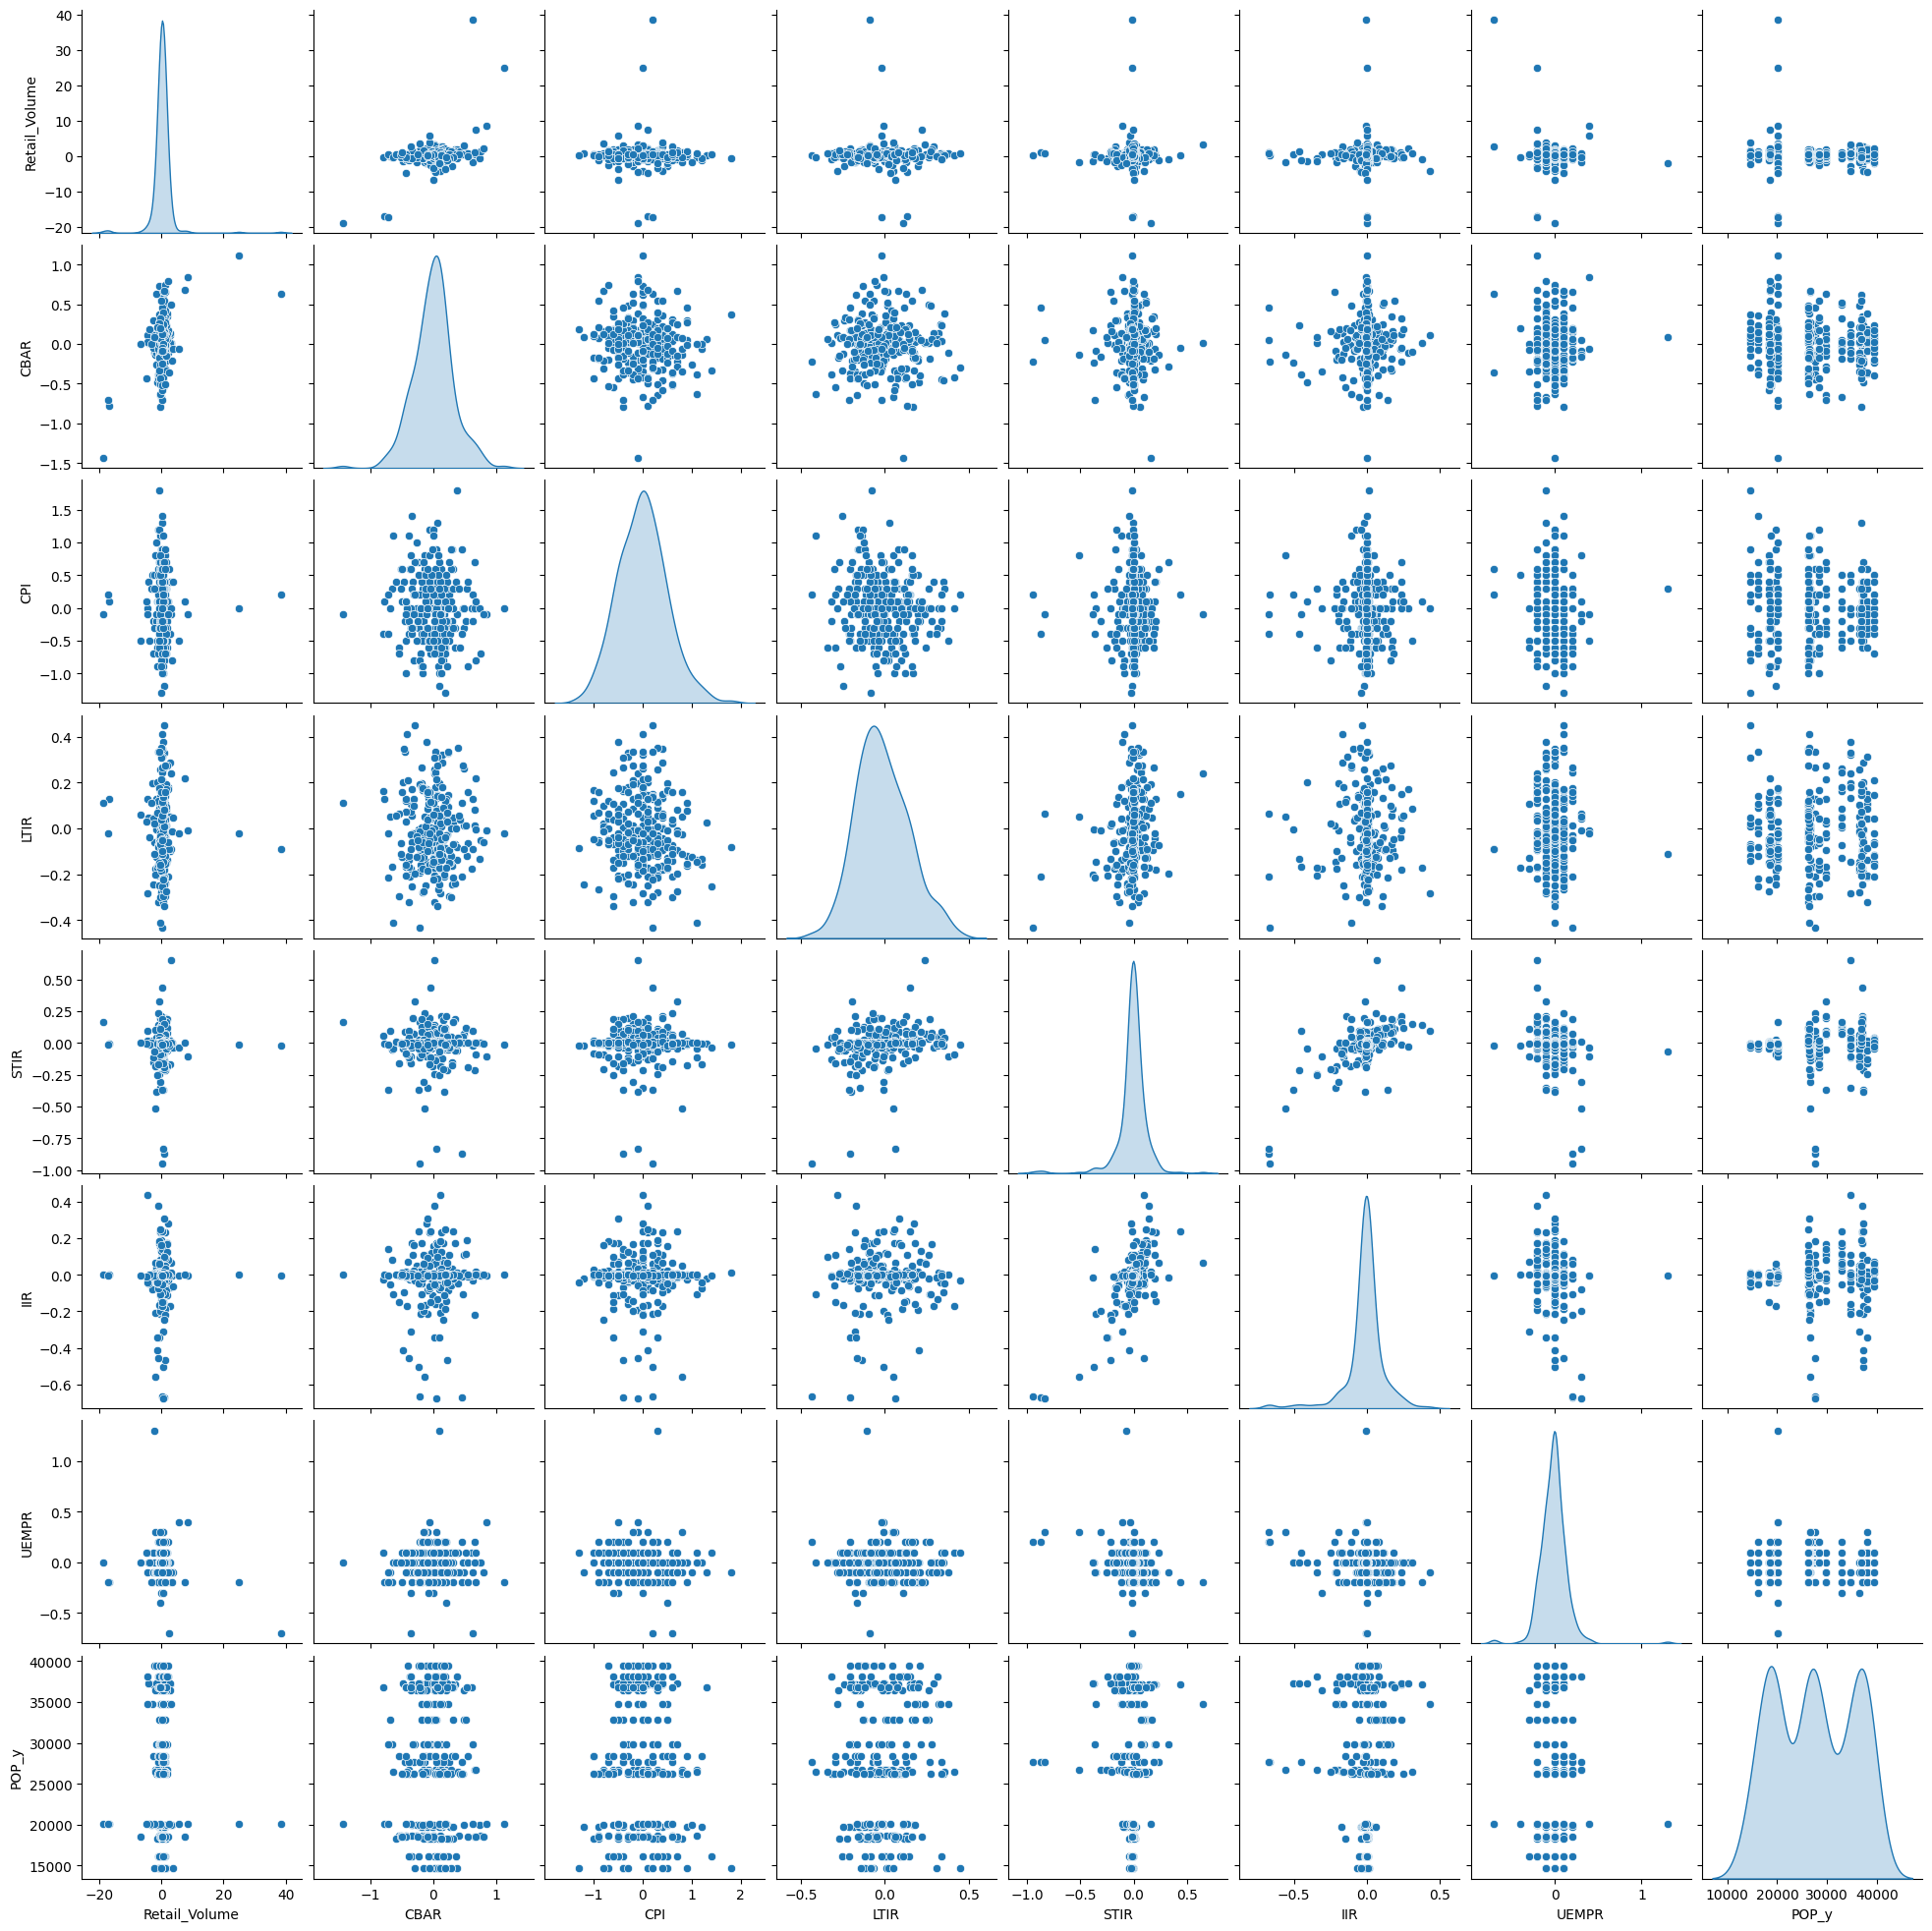

In [211]:
sns.pairplot(df_stationary, diag_kind='kde', markers='o')

# **CCF**

In [212]:
df_stationary

Retail_Volume      CBAR  CPI    LTIR      STIR       IIR  UEMPR  \
DATE                                                                       
1999-03            0.8 -0.182699 -0.1  0.1990 -0.046704 -0.192800   -0.2   
1999-04           -0.4 -0.091516  0.0 -0.1474 -0.350241 -0.216100   -0.1   
1999-05            0.7  0.030533 -0.3  0.1793 -0.117503 -0.158100   -0.2   
1999-06            0.0  0.137358  0.0  0.3207  0.047730  0.012200   -0.1   
1999-07            0.9  0.243858 -0.3  0.3327  0.049773 -0.042300   -0.1   
...                ...       ...  ...     ...       ...       ...    ...   
2021-08            0.4 -0.517331  0.6 -0.1100 -0.002773 -0.001578    0.0   
2021-09            0.0  0.550611 -0.9  0.1600  0.002545 -0.001260   -0.2   
2021-10            1.1 -0.501962  0.6  0.1600 -0.004764 -0.001053   -0.2   
2021-11            0.2 -0.091726  0.0 -0.1000 -0.017554 -0.002824    0.0   
2021-12            0.4 -0.244828 -0.2 -0.0500 -0.014593 -0.003135   -0.1   

                POP_y  
DATE                   
1999-03  34722.916667  
1999-04  34722.916667  
1999-05  34722.916667  
1999-06  34722.916667  
1999-07  34722.916667  
...               ...  
2021-08  18517.000000  
2021-09  18517.000000  
2021-10  18517.000000  
2021-11  18517.000000  
2021-12  18517.000000  

[274 rows x 8 columns]

## CCF

In [213]:
from statsmodels.tsa.stattools import ccf 

def top_ccf_values(series1, series2, top_n=3):
    ccf_values = ccf(series1, series2)
    abs_values_with_index = [(i, val) for i, val in enumerate(ccf_values)]
    top_values = sorted(abs_values_with_index, key=lambda x: abs(x[1]), reverse=True)[:top_n]
    
    print("Top CCF Values:")
    for idx, value in top_values:
        print(f"Index: {idx}, Value: {value}")

    return top_values



In [214]:
df_stationary.shape

(274, 8)

In [215]:
df_stationary

Retail_Volume      CBAR  CPI    LTIR      STIR       IIR  UEMPR  \
DATE                                                                       
1999-03            0.8 -0.182699 -0.1  0.1990 -0.046704 -0.192800   -0.2   
1999-04           -0.4 -0.091516  0.0 -0.1474 -0.350241 -0.216100   -0.1   
1999-05            0.7  0.030533 -0.3  0.1793 -0.117503 -0.158100   -0.2   
1999-06            0.0  0.137358  0.0  0.3207  0.047730  0.012200   -0.1   
1999-07            0.9  0.243858 -0.3  0.3327  0.049773 -0.042300   -0.1   
...                ...       ...  ...     ...       ...       ...    ...   
2021-08            0.4 -0.517331  0.6 -0.1100 -0.002773 -0.001578    0.0   
2021-09            0.0  0.550611 -0.9  0.1600  0.002545 -0.001260   -0.2   
2021-10            1.1 -0.501962  0.6  0.1600 -0.004764 -0.001053   -0.2   
2021-11            0.2 -0.091726  0.0 -0.1000 -0.017554 -0.002824    0.0   
2021-12            0.4 -0.244828 -0.2 -0.0500 -0.014593 -0.003135   -0.1   

                POP_y  
DATE                   
1999-03  34722.916667  
1999-04  34722.916667  
1999-05  34722.916667  
1999-06  34722.916667  
1999-07  34722.916667  
...               ...  
2021-08  18517.000000  
2021-09  18517.000000  
2021-10  18517.000000  
2021-11  18517.000000  
2021-12  18517.000000  

[274 rows x 8 columns]

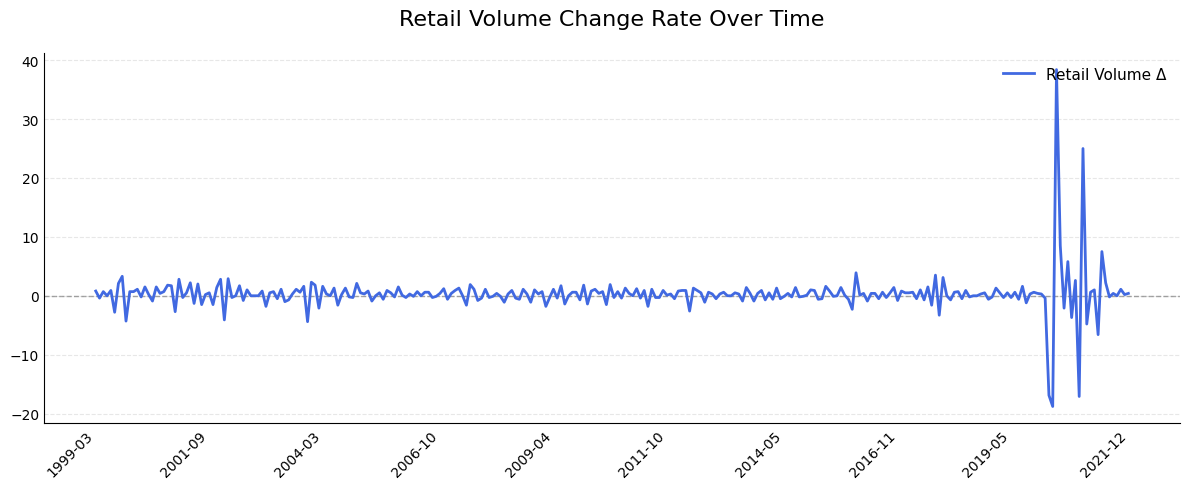

In [216]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 5))
plt.axhline(0, color='grey', linewidth=1, linestyle='--', alpha=0.7)  # Zero baseline

# Plot Retail Volume
plt.plot(
    df_stationary.index,
    df_stationary['Retail_Volume'],
    color='royalblue',
    linewidth=2,
    label='Retail Volume Δ'
)

# Title and labels
plt.title("Retail Volume Change Rate Over Time", fontsize=16, pad=20)


# X-axis ticks
x_ticks = np.linspace(0, len(df_stationary.index) - 1, 10, dtype=int)
plt.xticks(
    ticks=x_ticks,
    labels=[df_stationary.index[i].strftime('%Y-%m') if hasattr(df_stationary.index[i], 'strftime') else str(df_stationary.index[i]) for i in x_ticks],
    rotation=45,
    ha='right'
)

# Minimalist style
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Gridlines
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Legend
plt.legend(loc='upper right', frameon=False, fontsize=11)

# Tight layout for spacing
plt.tight_layout()
plt.show()


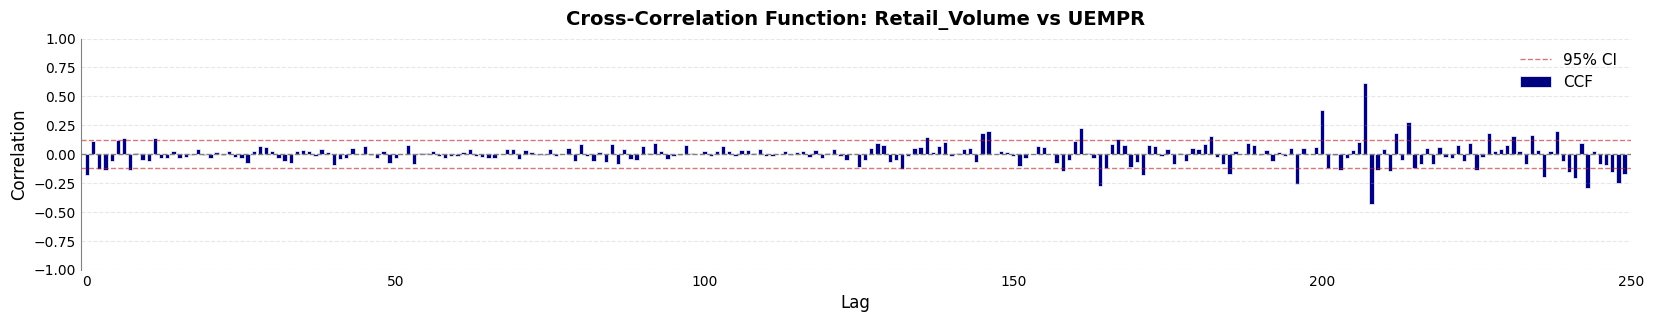

In [297]:
utils.ccf_plot(df_stationary["Retail_Volume"], df_stationary['UEMPR'], nlags=250)


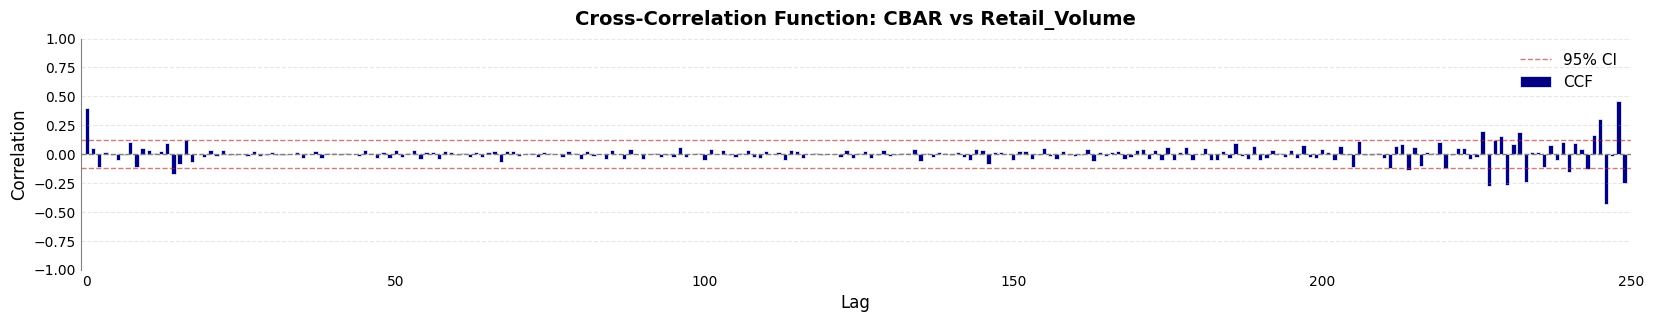

In [218]:
utils.ccf_plot(df_stationary["CBAR"], df_stationary['Retail_Volume'], nlags=250)


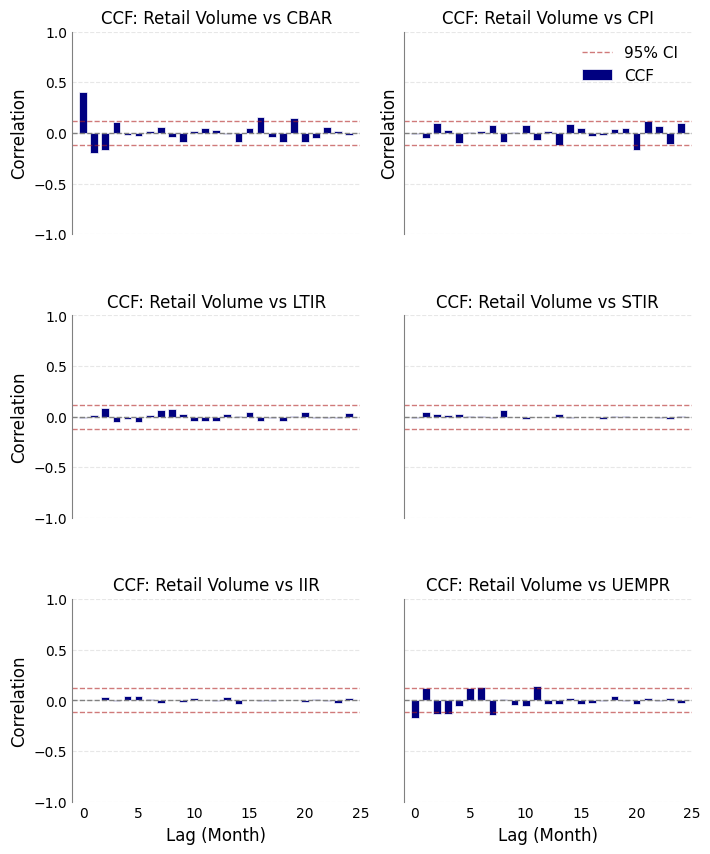

In [219]:
import matplotlib.pyplot as plt

# Create subplots: 3 rows, 2 columns, with gaps between axes
fig, axes = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.15)  # Add vertical and horizontal gaps

axes = axes.flatten()

utils.ccf_plot(df_stationary["Retail_Volume"], df_stationary['CBAR'], nlags=25, ax=axes[0])
axes[0].set_title("CCF: Retail Volume vs CBAR")
axes[0].set_xlabel("")
axes[0].get_legend().remove()  # Remove legend

utils.ccf_plot(df_stationary["Retail_Volume"], df_stationary["CPI"], nlags=25, ax=axes[1])
axes[1].set_title("CCF: Retail Volume vs CPI")
axes[1].set_xlabel("")

utils.ccf_plot(df_stationary["Retail_Volume"], df_stationary["LTIR"], nlags=25, ax=axes[2])
axes[2].set_title("CCF: Retail Volume vs LTIR")
axes[2].set_xlabel("")
axes[2].get_legend().remove()

utils.ccf_plot(df_stationary["Retail_Volume"], df_stationary["STIR"], nlags=25, ax=axes[3])
axes[3].set_title("CCF: Retail Volume vs STIR")
axes[3].set_xlabel("")
axes[3].set_ylabel("")
axes[3].get_legend().remove()

utils.ccf_plot(df_stationary["Retail_Volume"], df_stationary["IIR"], nlags=25, ax=axes[4])
axes[4].set_title("CCF: Retail Volume vs IIR")
axes[4].set_xlabel("Lag (Month)")
axes[4].get_legend().remove()

utils.ccf_plot(df_stationary["Retail_Volume"], df_stationary["UEMPR"], nlags=25, ax=axes[5])
axes[5].set_title("CCF: Retail Volume vs UEMPR")
axes[5].set_xlabel("Lag (Month)")
axes[5].set_ylabel("")
axes[5].get_legend().remove()

plt.show()


cpi 20
uempr 0 2 3 6 7 11
cbar 0 1 2 16 19

In [220]:
import pandas as pd
import numpy as np

cbr = ccf(df_stationary["Retail_Volume"], df_stationary['CBAR'])
cpi = ccf(df_stationary["Retail_Volume"], df_stationary['CPI'])
ltir = ccf(df_stationary["Retail_Volume"], df_stationary['LTIR'])
stir = ccf(df_stationary["Retail_Volume"], df_stationary['STIR'])
iir = ccf(df_stationary["Retail_Volume"], df_stationary['IIR'])
uempr = ccf(df_stationary["Retail_Volume"], df_stationary['UEMPR'])


# Create a DataFrame from the absolute values of the arrays
df_abs_values = pd.DataFrame({
    'CBAR': np.abs(cbr),
    'CPI': np.abs(cpi),
    # 'LTIR': np.abs(ltir),
    # 'STIR': np.abs(stir),
    # 'IIR': np.abs(iir),
    'UEMPR': np.abs(uempr)
})




df_abs_values['Average'] = df_abs_values.mean(axis=1)
filtered_df = df_abs_values[df_abs_values.drop(columns=['Average']).ge(0.1).any(axis=1)]
filtered_df.sort_values(by='Average', ascending=False).head(10)



CBAR       CPI     UEMPR   Average
254  0.402515  0.051948  0.898767  0.451077
249  0.103307  0.894243  0.176447  0.391332
261  0.314478  0.114854  0.683976  0.371103
231  0.459448  0.490686  0.159576  0.369903
251  0.348466  0.456140  0.263199  0.355935
207  0.213902  0.149252  0.611718  0.324957
235  0.422147  0.510049  0.037153  0.323117
237  0.544735  0.363107  0.028719  0.312187
252  0.090656  0.278768  0.558971  0.309465
223  0.617787  0.202923  0.061929  0.294213

## exploring crysis periods

March 2020 – June 2020

September 2008 - March 2009

In [221]:
from scipy.stats import norm

import pandas as pd

# Creating the data for the table
data = {
    "Crisis Interval": [(90,108), (123,153), (224,240), (60,84),
                      (132,156), (72,96), (12,24), (132,156), (60,72), (132,153)],
    "Crisis Pair": ["GFC - Dot-com", "COVID - GFC", "COVID - Dot-com", "GFC - Eurozone", 
                    "COVID - Eurozone", "Dot-com - Eurozone", "GFC - Yellow Vests", 
                    "COVID - Yellow Vests", "Dot-com - Yellow Vests", "Eurozone - Yellow Vests"],
}



def ccf_plot_custom(x, y, nlags=20, alpha=0.05,intervals=None,text=None):
    """
    Plot the Cross-Correlation Function (CCF) between two time series.

    Parameters:
    -----------
    x : array-like
        First time series.
    y : array-like
        Second time series.
    nlags : int
        Number of lags to compute.
    alpha : float
        Significance level for confidence intervals.

    Returns:
    --------
    Displays a CCF plot.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Calculate CCF values
    ccf_vals = ccf(x, y, adjusted=True )[:nlags]  # extract only the values

    # Calculate standard error
    n = len(x)
    std_error = 1 / np.sqrt(n)

    # Calculate the z-score corresponding to the alpha value (for confidence interval)
    z_score = norm.ppf(1 - alpha / 2)  # Two-tailed test: 1 - alpha / 2

    # Calculate confidence interval
    confint_upper = std_error * z_score
    confint_lower = -std_error * z_score

    # Plot
    lags = np.arange(nlags)
    plt.figure(figsize=(10, 4))
    plt.bar(lags, ccf_vals, width=0.3, color='blue', edgecolor='black',label='CCF')

    # Plot confidence intervals
    plt.axhline(y=0, color='black', linewidth=1)
    plt.axhline(y=confint_upper, color='red', linestyle='dashed', label=f'{100*(1-alpha)}% CI')
    plt.axhline(y=confint_lower, color='red', linestyle='dashed')

    # Set fixed y-axis limits from -1 to 1
    plt.ylim(-1, 1)

    plt.xlabel("Lag")
    plt.ylabel("Cross-Correlation")
    plt.title("Cross-Correlation Function (CCF)")
    
    plt.xticks(np.arange(9, 274, 12))

    yy = np.linspace(-10, 10, 100)

    x1 = np.full_like(yy, intervals[0] )  # Line at y=2
    x2 = np.full_like(yy, intervals[1])  # Line at y=6
    # Fill between the two lines
    plt.fill_betweenx(yy, x1, x2, color='skyblue', alpha=0.5)
    plt.text(intervals[0],0.80,s=text, fontsize=9, ha='left')


    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    

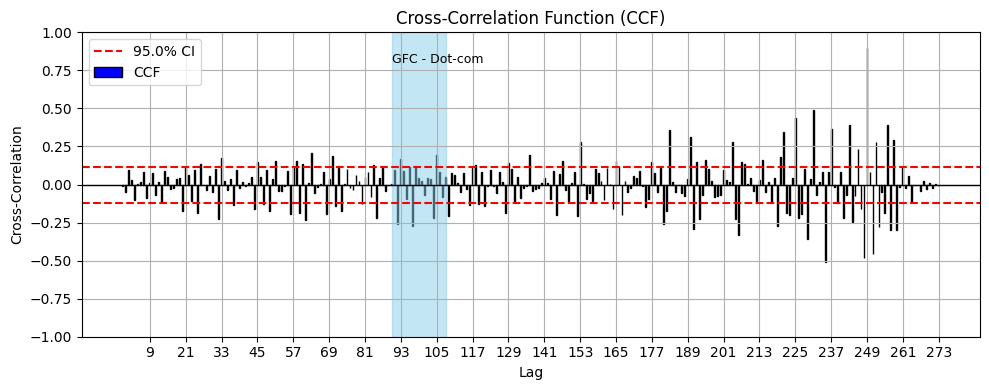

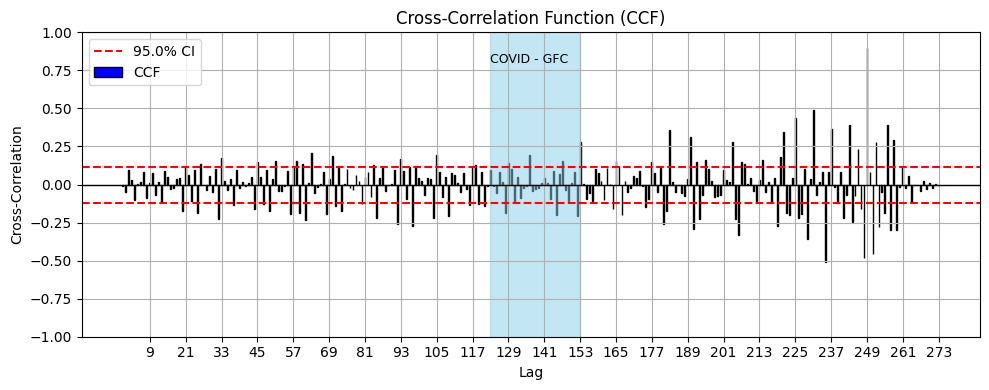

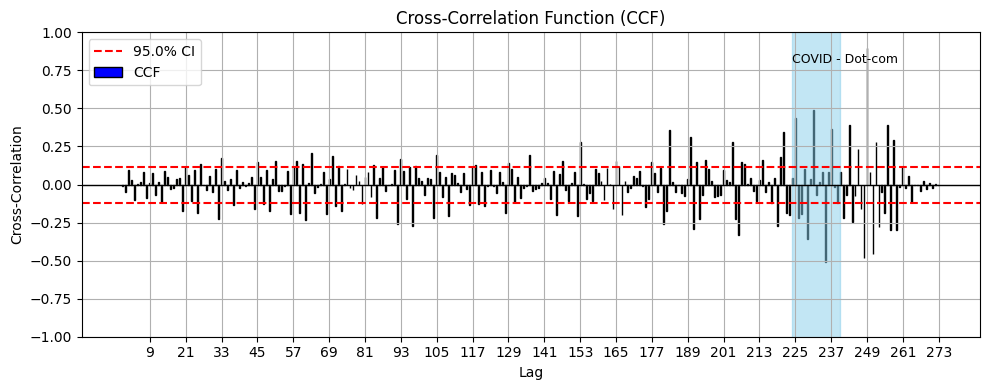

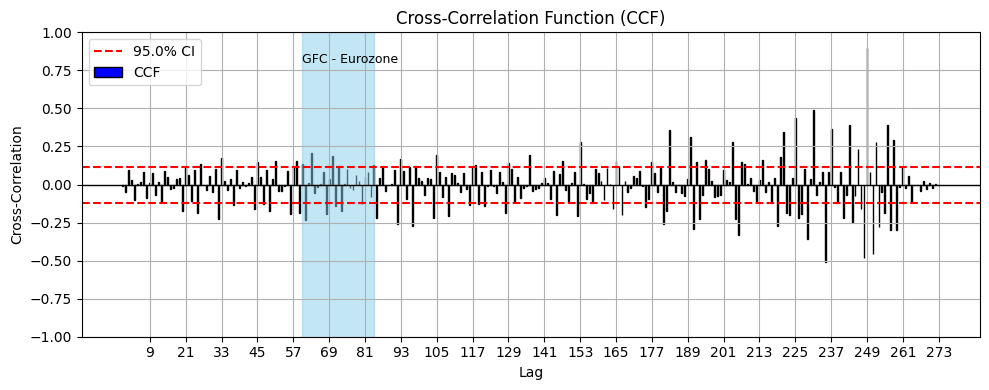

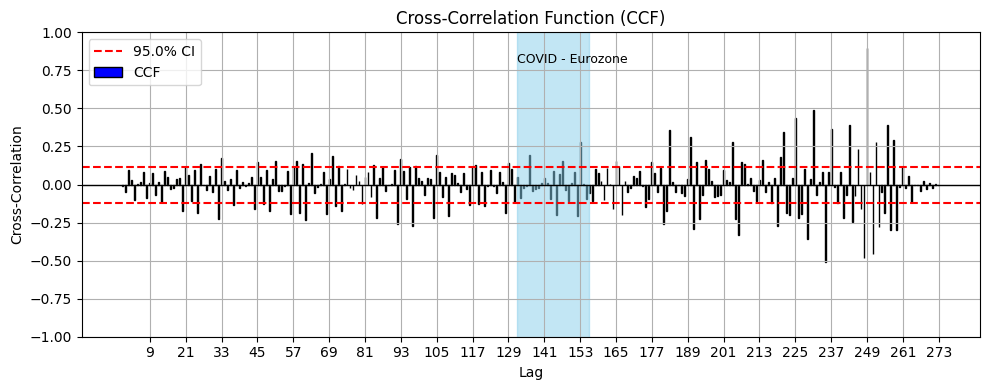

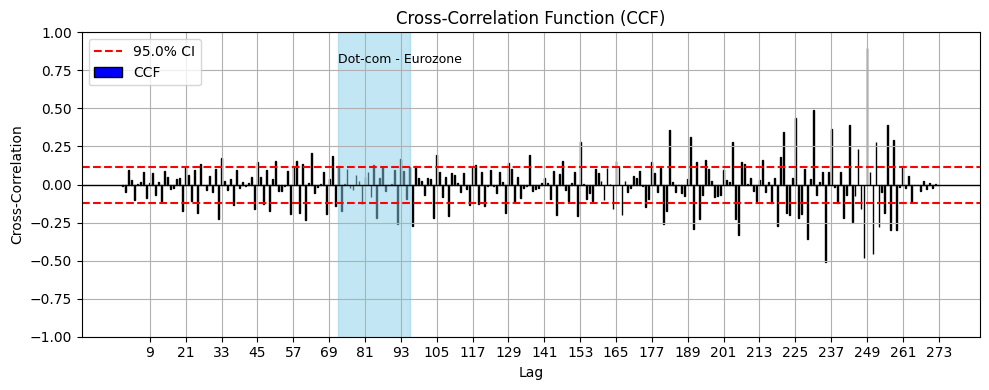

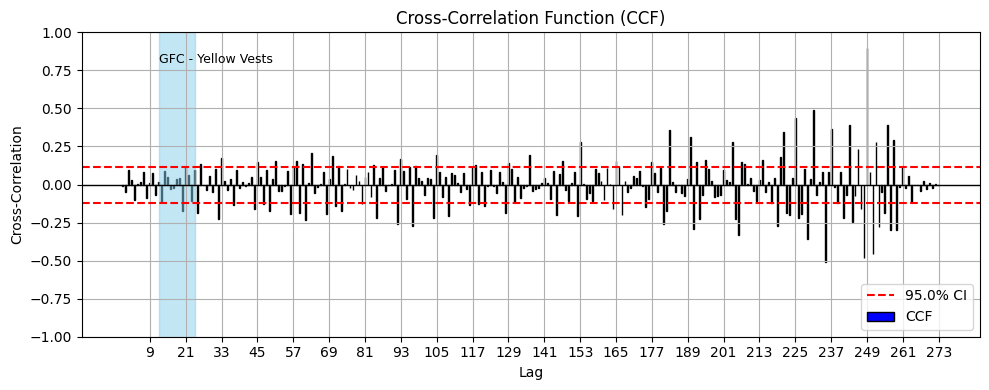

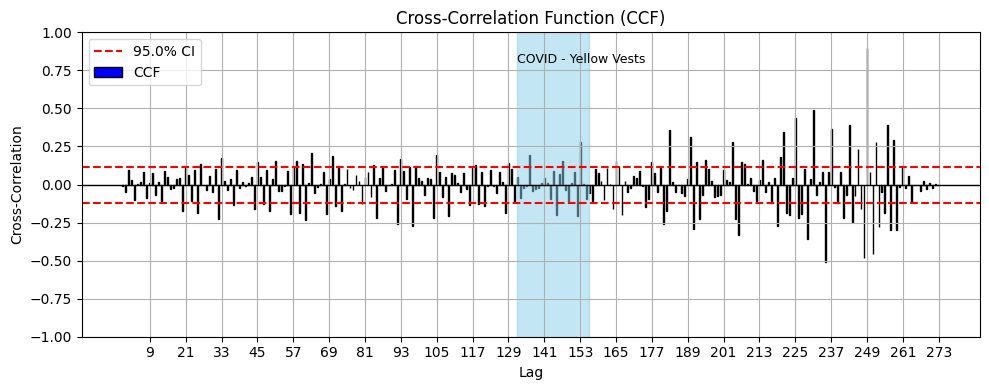

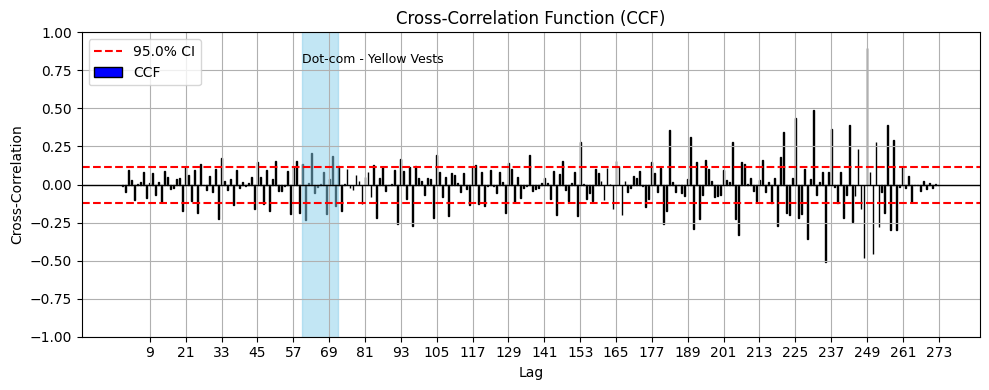

In [222]:
for i in range(9):
    ccf_plot_custom(df_stationary["Retail_Volume"],df_stationary['CPI'],274,intervals=data['Crisis Interval'][i],text=data['Crisis Pair'][i])

In [223]:
import pandas as pd

def crysis_periods_data(col,df_stationary):
    """
    Processes the provided DataFrame for defined crisis periods and returns a combined DataFrame
    with columns for each crisis period for all numeric columns.

    Parameters:
    - df_stationary: pandas DataFrame with a datetime index and numeric columns.

    Returns:
    - pandas DataFrame with columns for each crisis period for all numeric columns.
    """
    # Define the crisis intervals
    crisis_periods_fixed = {
        "dotcom": "2001-03",
        "gfc": "2008-09",
        "eurocrisis": "2009-11",
        "yellowvests": "2018-11",
        "covid": "2020-03"
    }



    df = df_stationary.copy()

    # Convert index to datetime if not already
    df.index = pd.to_datetime(df.index)

    # Collect renamed subsets
    frames = []

    for name, start in crisis_periods_fixed.items():
        if name == col:
            print(f"Processing crisis period: {name} from {start}")
            end = pd.to_datetime(start) + pd.DateOffset(months=23)
            sub = df.loc[start:end].copy()
            sub.columns = [f"{col}" for col in sub.columns]
            sub.reset_index(drop=True, inplace=True)
            frames.append(sub)
            break
        else:
            continue


    # Combine on index
    result = pd.concat(frames, axis=1)

    
    # Final DataFrame with columns for all numeric columns across crisis periods
    return result

In [224]:
crysis_periods_data("covid",df_stationary)

Processing crisis period: covid from 2020-03


Retail_Volume      CBAR  CPI  LTIR      STIR       IIR  UEMPR     POP_y
0           -16.9 -0.781107  0.1  0.13 -0.007786  0.002595   -0.2  20141.75
1           -18.8 -1.435585 -0.1  0.11  0.162586  0.000160    0.0  20141.75
2            38.4  0.626449  0.2 -0.09 -0.017900 -0.004723   -0.7  20141.75
3             8.5  0.840441 -0.1 -0.01 -0.104050 -0.004273    0.4  20141.75
4            -2.1  0.092604  0.3 -0.11 -0.068130 -0.005091    1.3  20141.75
5             5.8 -0.061679 -0.5 -0.02 -0.035584 -0.002532    0.4  20141.75
6            -3.7  0.185151 -0.5 -0.04 -0.011649 -0.000845    0.0  20141.75
7             2.6 -0.354217  0.6 -0.09 -0.017773 -0.001708   -0.7  20141.75
8           -17.1 -0.710952  0.2 -0.02 -0.011721 -0.001575   -0.2  20141.75
9            25.0  1.120763  0.0 -0.02 -0.017234 -0.000133   -0.2  20141.75
10           -4.8 -0.431022  0.1  0.03 -0.009059 -0.009415    0.1  20141.75
11            0.6 -0.092762 -0.3  0.16  0.006050  0.002243    0.2  18517.00
12            1.0  0.665409  0.7  0.08  0.002013 -0.000245    0.0  18517.00
13           -6.6  0.000000 -0.5  0.06  0.000937 -0.002289    0.0  18517.00
14            7.5  0.676382  0.1  0.22 -0.001945  0.001349   -0.2  18517.00
15            2.2  0.793991 -0.1 -0.06 -0.002814  0.000580   -0.1  18517.00
16           -0.2 -0.439314 -0.1 -0.16 -0.001909 -0.002396    0.0  18517.00
17            0.4 -0.517331  0.6 -0.11 -0.002773 -0.001578    0.0  18517.00
18            0.0  0.550611 -0.9  0.16  0.002545 -0.001260   -0.2  18517.00
19            1.1 -0.501962  0.6  0.16 -0.004764 -0.001053   -0.2  18517.00
20            0.2 -0.091726  0.0 -0.10 -0.017554 -0.002824    0.0  18517.00
21            0.4 -0.244828 -0.2 -0.05 -0.014593 -0.003135   -0.1  18517.00

In [225]:
df_stationary = df_stationary.drop(columns=["POP_y"])

In [226]:
from scipy.stats import spearmanr

def calculate_correlation_and_p_values(col, df_stationary, insignificant=None):
    """
    Calculate the correlation and p-values for a given column and DataFrame.

    Parameters:
    - col: str, the column name to analyze.
    - df_stationary: pandas DataFrame, the input data.
    - insignificant: str, if "zero", set insignificant correlations to zero;
                      if "weighted", give less weight to insignificant values.

    Returns:
    - corr_matrix: pandas DataFrame, the correlation matrix.
    - p_value_matrix: pandas DataFrame, the p-value matrix.
    """
    # Calculate the correlation and p-values
    corr_matrix, p_value_matrix = spearmanr(crysis_periods_data(col, df_stationary))

    # Add column names to the correlation and p-value matrices
    columns = crysis_periods_data(col, df_stationary).columns
    corr_matrix = pd.DataFrame(corr_matrix, index=columns, columns=columns)
    p_value_matrix = pd.DataFrame(p_value_matrix, index=columns, columns=columns)

    if insignificant == "zero":
        # Set correlation values to zero where p-value is not significant
        corr_matrix[p_value_matrix >= 0.05] = 0
    elif insignificant == "weighted":
        # Reduce the weight of insignificant correlations
        corr_matrix = corr_matrix * (1 - p_value_matrix)

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix of {col}' + (' (Significant Values Only)' if insignificant == "zero" else ' (Weighted)' if insignificant == "weighted" else ''))
    plt.show()

    return corr_matrix, p_value_matrix


Processing crisis period: dotcom from 2001-03
Processing crisis period: dotcom from 2001-03


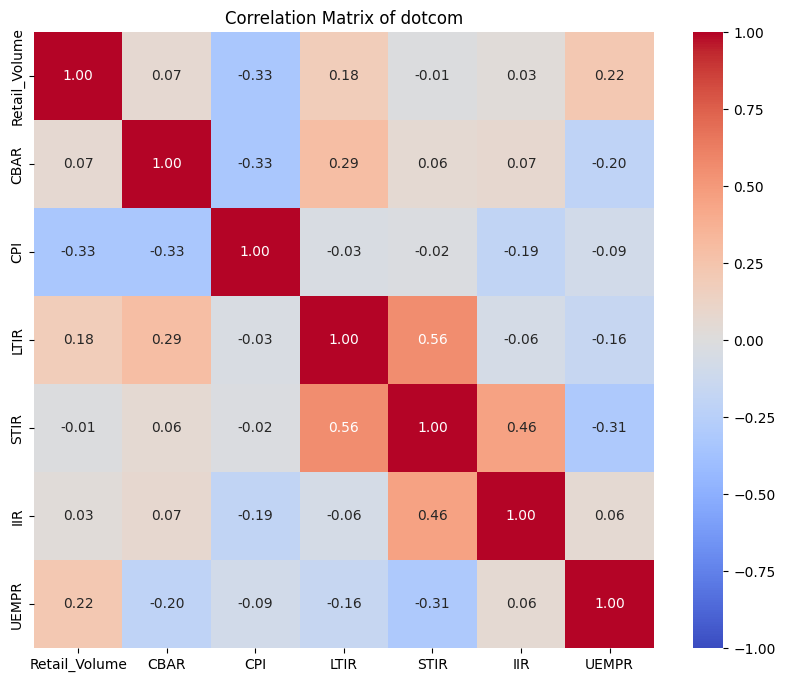

In [227]:
dotcom_corr, dotcom_p_value = calculate_correlation_and_p_values("dotcom",df_stationary)

Processing crisis period: gfc from 2008-09
Processing crisis period: gfc from 2008-09


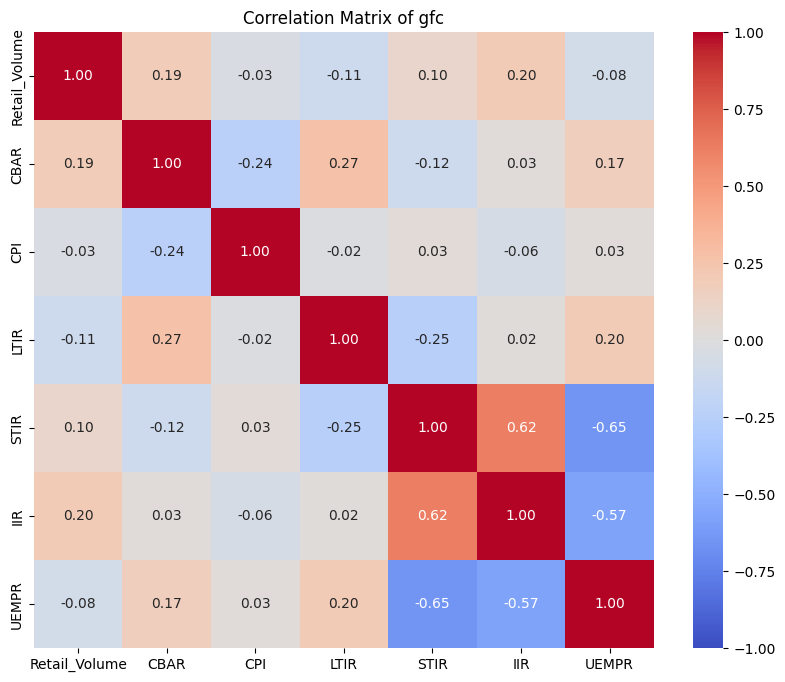

In [228]:
gfc_corr, gfc_p_value = calculate_correlation_and_p_values("gfc",df_stationary)

Processing crisis period: eurocrisis from 2009-11
Processing crisis period: eurocrisis from 2009-11


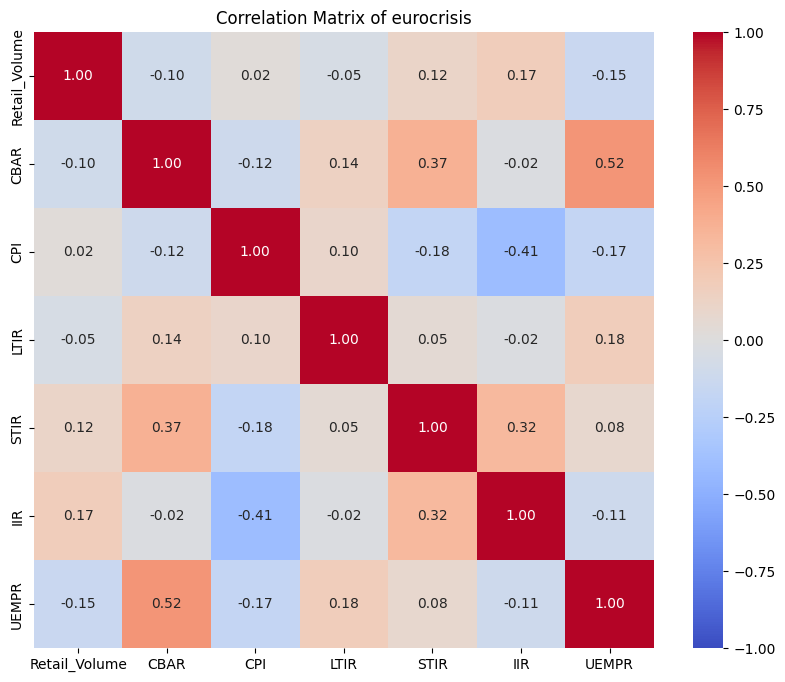

In [229]:
eurocrisis_corr, eurocrisis_p_value = calculate_correlation_and_p_values("eurocrisis",df_stationary)

Processing crisis period: yellowvests from 2018-11
Processing crisis period: yellowvests from 2018-11


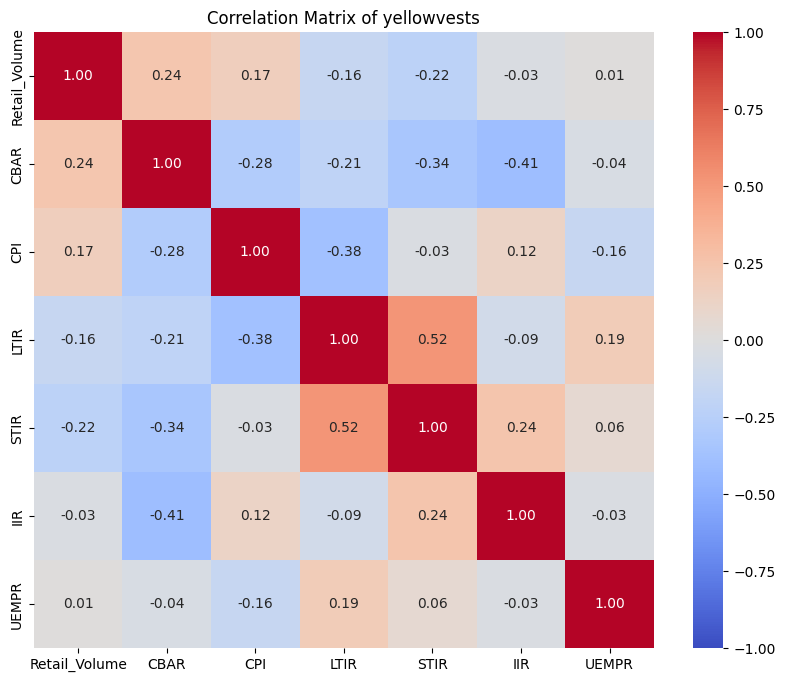

In [230]:
yellowvests_corr, yellowvests_p_value = calculate_correlation_and_p_values("yellowvests",df_stationary)

Processing crisis period: covid from 2020-03
Processing crisis period: covid from 2020-03


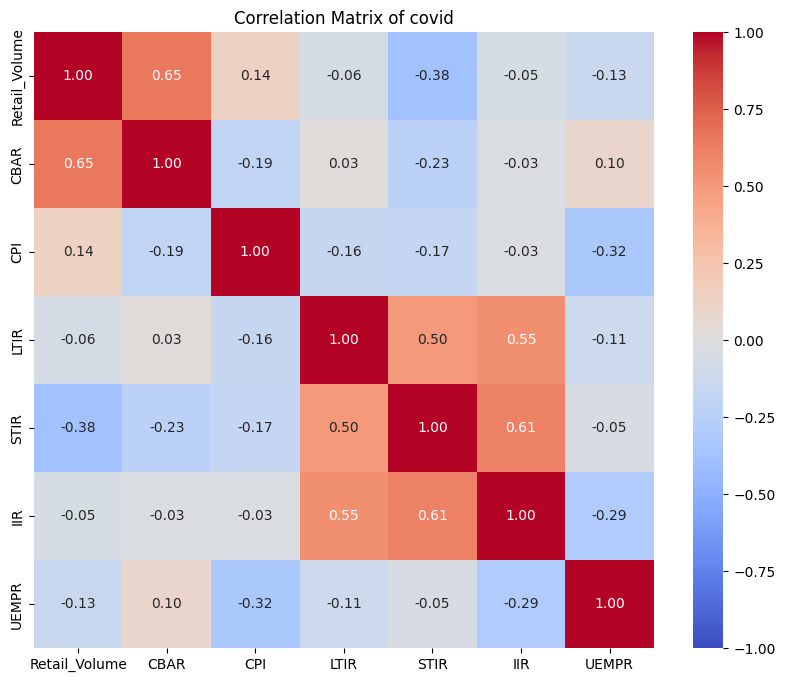

In [231]:
covid_corr, covid_p_value = calculate_correlation_and_p_values("covid",df_stationary)

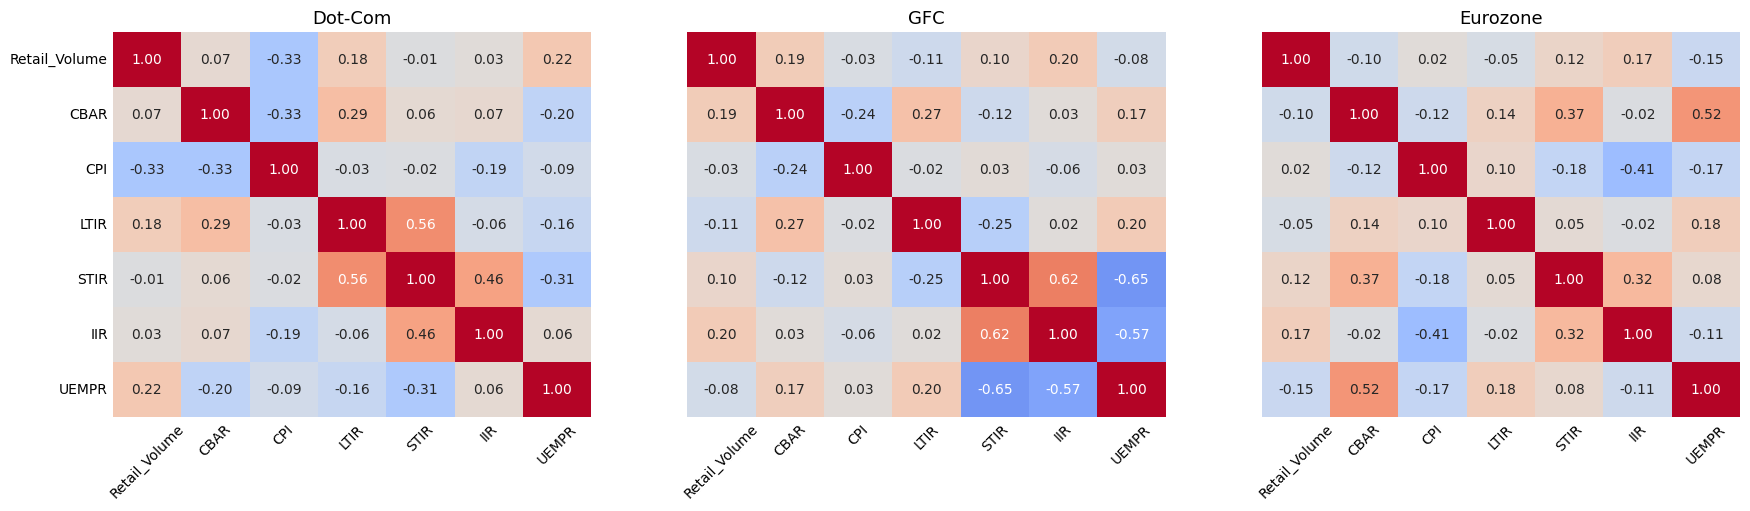

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

corr_matrices = [
    ("Dot-Com", dotcom_corr),
    ("GFC", gfc_corr),
    ("Eurozone", eurocrisis_corr)
]

fig, axes = plt.subplots(1, len(corr_matrices), figsize=(21, 5), sharex=True, sharey=True)

# Colormap settings
vmin, vmax = -1, 1
cmap = 'coolwarm'
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw heatmaps without individual colorbars
for ax, (title, corr) in zip(axes, corr_matrices):
    sns.heatmap(
        corr,
        annot=True,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cbar=False,
        fmt=".2f"
    )
    ax.set_title(title, fontsize=13)
    ax.tick_params(length=0)
    ax.tick_params(axis='x', rotation=45)
    
    ax.tick_params(axis='y', rotation=0)

plt.show()


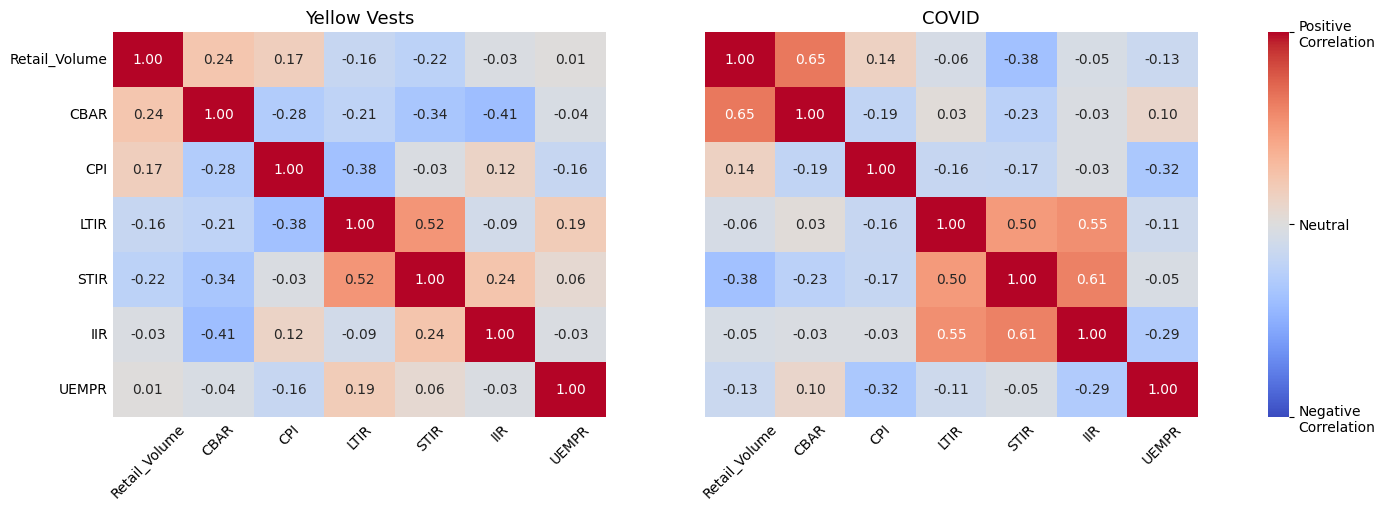

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

corr_matrices = [
    ("Yellow Vests", yellowvests_corr),
    ("COVID", covid_corr)
]

fig, axes = plt.subplots(1, len(corr_matrices), figsize=(14, 5), sharex=True, sharey=True)

# Colormap settings
vmin, vmax = -1, 1
cmap = 'coolwarm'
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw heatmaps without individual colorbars
for ax, (title, corr) in zip(axes, corr_matrices):
    sns.heatmap(
        corr,
        annot=True,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cbar=False,
        fmt=".2f"
    )
    ax.set_title(title, fontsize=13)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(length=0)

    ax.tick_params(axis='y', rotation=0)
# Add shared colorbar to the right
cbar_ax = fig.add_axes([0.95, 0.11, 0.015, 0.77])  # [left, bottom, width, height]
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['Negative\nCorrelation', 'Neutral', 'Positive\nCorrelation'])

# Remove outline of colorbar
cbar.outline.set_visible(False)

plt.show()


In [234]:
np.triu_indices_from(dotcom_corr, k=1)

(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]),
 array([1, 2, 3, 4, 5, 6, 2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]))

In [235]:
dotcom_corr.values[np.triu_indices_from(dotcom_corr, k=1)]

array([ 0.07022938, -0.33077177,  0.17971743, -0.01439484,  0.02791727,
        0.2232256 , -0.33144508,  0.28956522,  0.06173913,  0.07217391,
       -0.20419345, -0.03288146, -0.01972887, -0.18852035, -0.09228077,
        0.55652174, -0.06434783, -0.15957976,  0.46086957, -0.30543222,
        0.05776902])

In [236]:
correlation, _ = spearmanr(dotcom_corr.values[np.triu_indices_from(dotcom_corr, k=1)], gfc_corr.values[np.triu_indices_from(gfc_corr, k=1)])
correlation

np.float64(0.17142857142857143)

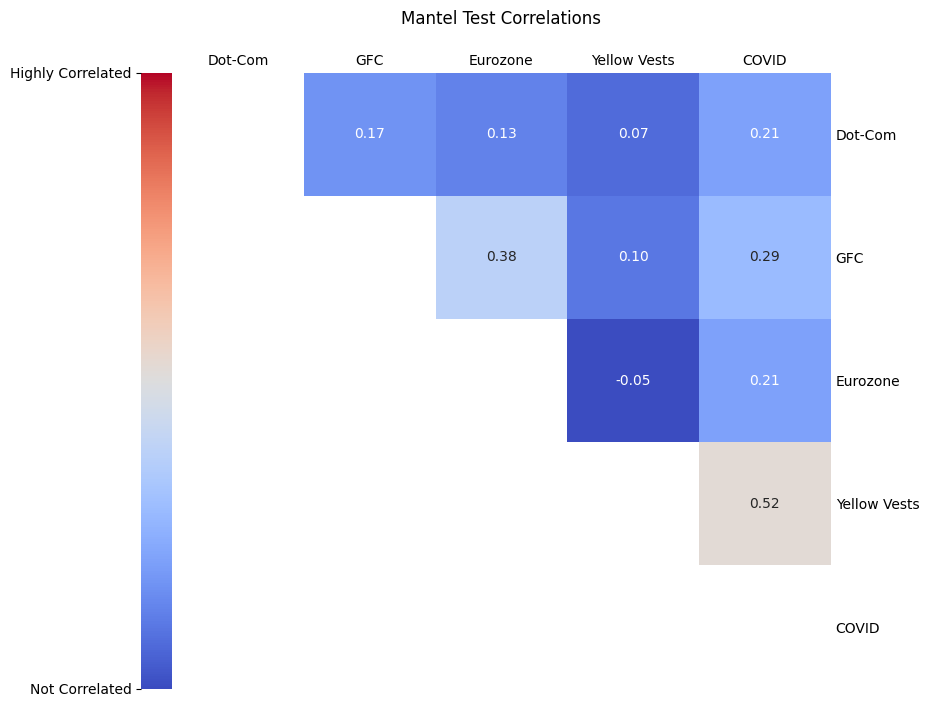

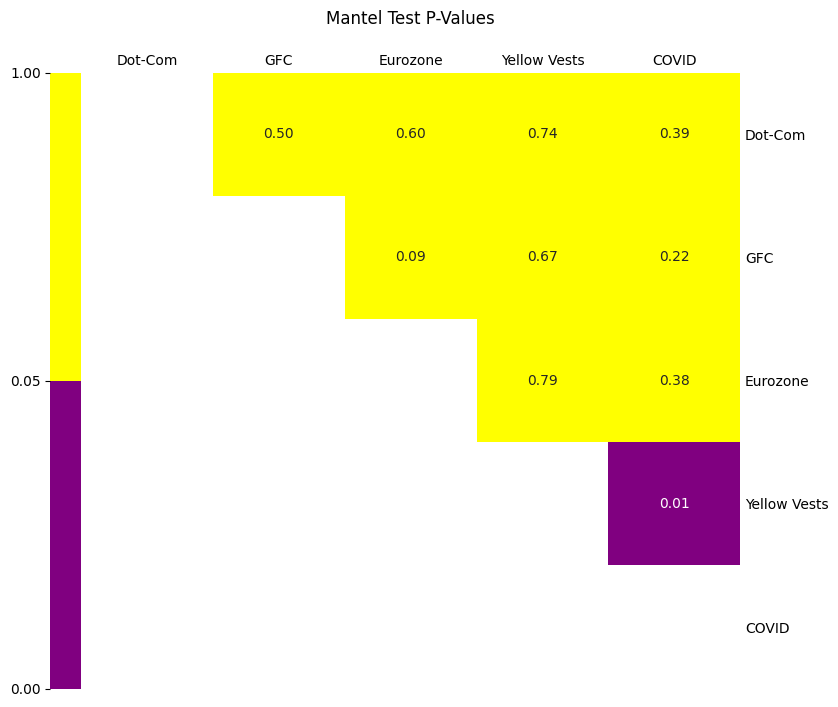

{('Dot-Com', 'GFC'): {'correlation': np.float64(0.17142857142857143),
  'p_value': np.float64(0.502)},
 ('Dot-Com', 'Eurozone'): {'correlation': np.float64(0.125974025974026),
  'p_value': np.float64(0.602)},
 ('Dot-Com', 'Yellow Vests'): {'correlation': np.float64(0.07402597402597402),
  'p_value': np.float64(0.744)},
 ('Dot-Com', 'COVID'): {'correlation': np.float64(0.20779220779220778),
  'p_value': np.float64(0.392)},
 ('GFC', 'Eurozone'): {'correlation': np.float64(0.38311688311688313),
  'p_value': np.float64(0.087)},
 ('GFC', 'Yellow Vests'): {'correlation': np.float64(0.1012987012987013),
  'p_value': np.float64(0.669)},
 ('GFC', 'COVID'): {'correlation': np.float64(0.2857142857142857),
  'p_value': np.float64(0.217)},
 ('Eurozone',
  'Yellow Vests'): {'correlation': np.float64(-0.05454545454545454), 'p_value': np.float64(0.794)},
 ('Eurozone', 'COVID'): {'correlation': np.float64(0.20779220779220778),
  'p_value': np.float64(0.381)},
 ('Yellow Vests', 'COVID'): {'correlation':

In [237]:
import numpy as np
import seaborn as sns
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib.pyplot as plt

def mantel_test(matrix1, matrix2, permutations=50):
    """
    Perform a Mantel test between two distance matrices.

    Parameters:
    - matrix1: First distance matrix (2D numpy array).
    - matrix2: Second distance matrix (2D numpy array).
    - permutations: Number of permutations for significance testing.

    Returns:
    - correlation: Mantel correlation coefficient.
    - p_value: P-value from the Mantel test.
    """
    # Flatten the upper triangle of the matrices
    dist1 = squareform(matrix1, checks=False)
    dist2 = squareform(matrix2, checks=False)

    # Compute the Pearson correlation
    correlation, _ = spearmanr(dist1, dist2)

    # Permutation test
    permuted_correlations = []
    for _ in range(permutations):
        np.random.shuffle(dist2)
        permuted_corr, _ = spearmanr(dist1, dist2)
        permuted_correlations.append(permuted_corr)

    # Calculate p-value
    permuted_correlations = np.array(permuted_correlations)
    p_value = np.mean(np.abs(permuted_correlations) >= np.abs(correlation))

    return correlation, p_value

def mantel_test_visualization(matrices, labels, permutations=1000):
    """
    Perform Mantel tests between all pairs of matrices and visualize the results.

    Parameters:
    - matrices: List of distance matrices (2D numpy arrays).
    - labels: List of labels for the matrices.
    - permutations: Number of permutations for significance testing.

    Returns:
    - results: A dictionary with Mantel test results for each pair of matrices.
    """
    n = len(matrices)
    correlations = np.zeros((n, n))
    p_values = np.zeros((n, n))
    results = {}

    for i in range(n):
        for j in range(n):
            if i < j:
                corr, p_val = mantel_test(matrices[i], matrices[j], permutations)
                correlations[i, j] = corr
                p_values[i, j] = p_val
                results[(labels[i], labels[j])] = {"correlation": corr, "p_value": p_val}

    # Mask the upper triangle for better visualization
    mask = np.tril(np.ones_like(correlations, dtype=bool))

    
    # Visualization for correlations
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations,annot=True, mask=mask, xticklabels=labels, yticklabels=labels, cmap="coolwarm", fmt=".2f", linewidths=0,
                vmin=0, vmax=1, cbar_kws={"orientation": "vertical", "location": "left", "pad":0}, cbar=True)
    plt.gca().xaxis.tick_top()  # Move x labels to the top
    plt.gca().tick_params(length=0)
    plt.gca().yaxis.tick_right()  # Move y labels to the right
    plt.yticks(rotation=0)  # Rotate y labels
    plt.title("Mantel Test Correlations", pad=35)
    colorbar = plt.gca().collections[0].colorbar
    colorbar.set_ticks([0,1])
    colorbar.set_ticklabels(['Not Correlated', 'Highly Correlated'])
    
    plt.show()



    # Define custom colors and thresholds
    colors = ['purple', 'yellow']  # Colors for <=0.05 and >0.05
    boundaries = [0, 0.05, 1.0]   # Add a bit more than 1 to include 1 in the range

    # Create colormap and normalization
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries, ncolors=len(colors))

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(p_values, mask=mask, annot=True, xticklabels=labels, yticklabels=labels, 
                cmap=cmap, norm=norm, fmt=".2f", cbar=True, linewidths=0,vmin=0, vmax=1,
                cbar_kws={"orientation": "vertical", "location": "left", "pad":0})
    plt.gca().xaxis.tick_top()
    plt.gca().tick_params(length=0)
    plt.gca().yaxis.tick_right()
    plt.yticks(rotation=0)
    plt.title("Mantel Test P-Values", pad=35)
    colorbar = plt.gca().collections[0].colorbar
    colorbar.set_ticks([0,0.05,1])
    plt.show()

    return results

mantel_test_visualization([dotcom_corr, gfc_corr, eurocrisis_corr, yellowvests_corr, covid_corr],['Dot-Com', 'GFC', 'Eurozone', 'Yellow Vests', 'COVID'], permutations=1000)

In [238]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage



corrs = [c.values for c in [dotcom_corr, gfc_corr, eurocrisis_corr, yellowvests_corr, covid_corr]]

# Function to extract upper triangle (excluding diagonal)
def flatten_upper_triangle(matrix):
    idx = np.triu_indices_from(matrix, k=1)
    return matrix[idx]

# Flatten each correlation matrix
flattened_corrs = [flatten_upper_triangle(corr) for corr in corrs]

# Compute pairwise Euclidean distances
dist_matrix = squareform(pdist(flattened_corrs, metric='euclidean'))
sim_matrix = squareform(pdist(flattened_corrs, metric='cosine'))
cos_dist_matrix = 1 - sim_matrix  # similarity = 1 - cosine_distance


In [239]:
sim_matrix

array([[0.        , 0.69852954, 0.85057131, 0.74301448, 0.60438738],
       [0.69852954, 0.        , 0.66506224, 0.9315194 , 0.63561506],
       [0.85057131, 0.66506224, 0.        , 1.08256713, 0.84436994],
       [0.74301448, 0.9315194 , 1.08256713, 0.        , 0.40917289],
       [0.60438738, 0.63561506, 0.84436994, 0.40917289, 0.        ]])

In [240]:
cos_dist_matrix

array([[ 1.        ,  0.30147046,  0.14942869,  0.25698552,  0.39561262],
       [ 0.30147046,  1.        ,  0.33493776,  0.0684806 ,  0.36438494],
       [ 0.14942869,  0.33493776,  1.        , -0.08256713,  0.15563006],
       [ 0.25698552,  0.0684806 , -0.08256713,  1.        ,  0.59082711],
       [ 0.39561262,  0.36438494,  0.15563006,  0.59082711,  1.        ]])

In [241]:
percentile_1 = np.percentile(flatten_upper_triangle(dist_matrix), 1)
print("0.5 Percentile:", percentile_1)

0.5 Percentile: 1.1510425924476946


/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_3994/956989486.py:32: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='ward')


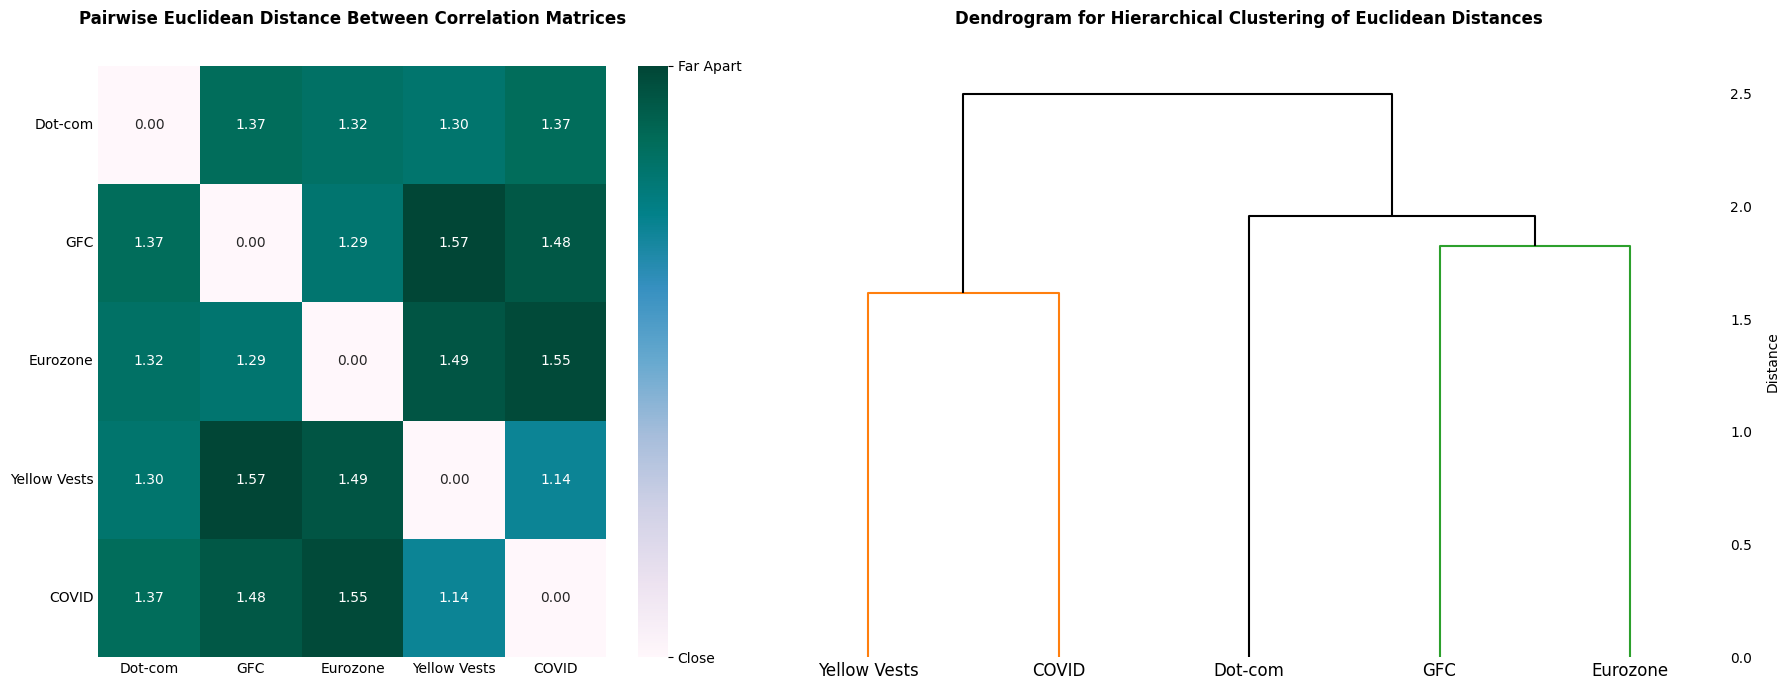

In [242]:
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [4, 6]})

# ---- Heatmap ----
sns.heatmap(
    dist_matrix,
    annot=True,
    cmap="PuBuGn",
    xticklabels=['Dot-com', 'GFC', 'Eurozone', 'Yellow Vests', 'COVID'],
    yticklabels=['Dot-com', 'GFC', 'Eurozone', 'Yellow Vests', 'COVID'],
    fmt=".2f",
    cbar=True,
    ax=axes[0]
)
axes[0].set_title("Pairwise Euclidean Distance Between Correlation Matrices", pad=30,fontweight='bold')
axes[0].tick_params(axis='x', bottom=True, labelbottom=True)
axes[0].tick_params(length=0)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)


# Customize color bar ticks
colorbar = axes[0].collections[0].colorbar
colorbar.set_ticks([np.min(dist_matrix), np.max(dist_matrix)])
colorbar.set_ticklabels(['Close', 'Far Apart'])


# ---- Dendrogram ----
Z = linkage(dist_matrix, method='ward')
dendrogram(
    Z,
    labels=['Dot-com', 'GFC', 'Eurozone', 'Yellow Vests', 'COVID'],
    color_threshold=1.95,
    ax=axes[1],
    above_threshold_color='black',
)
axes[1].set_title("Dendrogram for Hierarchical Clustering of Euclidean Distances", pad=30,fontweight='bold')
axes[1].set_ylabel("Distance",labelpad=10)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].tick_params(length=0)

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()


In [243]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

last = Z[-10:, 2]  # Son birleşmelerin mesafeleri
diffs = last[1:] - last[:-1]  # Aradaki farklar
threshold_suggestion = last[:-1][diffs.argmax()]  # En büyük sıçramanın olduğu yer

print("Suggested threshold:", threshold_suggestion)


Suggested threshold: 1.9570094558005497


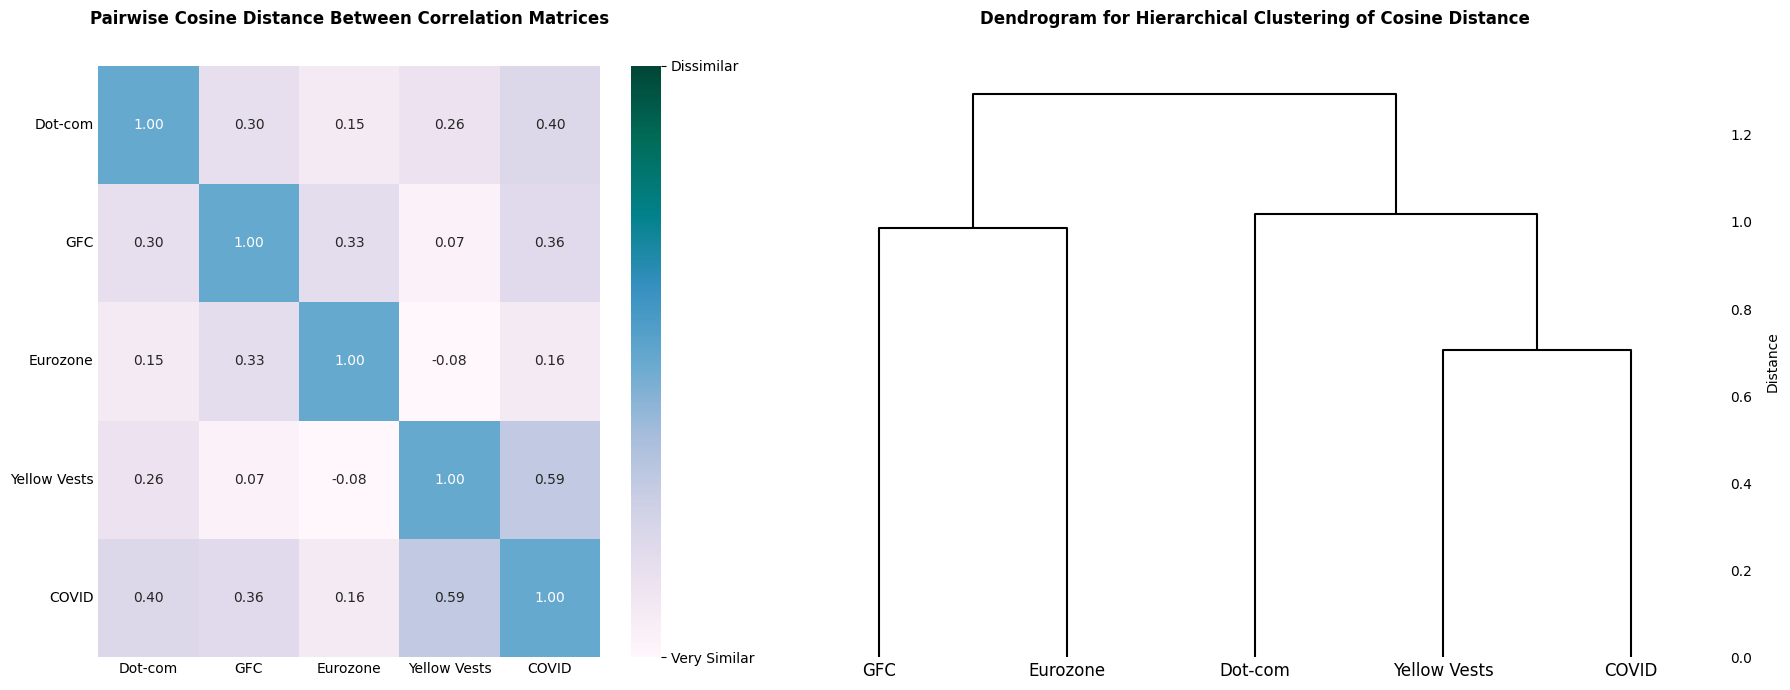

In [244]:
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [4, 6]})

# ---- Heatmap ----
sns.heatmap(
    cos_dist_matrix,
    annot=True,
    cmap="PuBuGn",
    xticklabels=['Dot-com', 'GFC', 'Eurozone', 'Yellow Vests', 'COVID'],
    yticklabels=['Dot-com', 'GFC', 'Eurozone', 'Yellow Vests', 'COVID'],
    fmt=".2f",
    cbar=True,  # Add color bar
    ax=axes[0],
    vmin=0,
    vmax=2
)

# Customize color bar ticks
colorbar = axes[0].collections[0].colorbar
colorbar.set_ticks([0, 2])
colorbar.set_ticklabels(['Very Similar','Dissimilar'])

axes[0].set_title("Pairwise Cosine Distance Between Correlation Matrices", pad=30,fontweight='bold')
axes[0].tick_params(axis='x', bottom=True, labelbottom=True)
axes[0].tick_params(length=0)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# ---- Dendrogram ----
Z = linkage(cos_dist_matrix, method='average')  # Use cosine similarity for linkage
dendrogram(
    Z,
    labels=['Dot-com', 'GFC', 'Eurozone', 'Yellow Vests', 'COVID'],
    color_threshold=0.53,
    ax=axes[1],
    above_threshold_color='black',
)
axes[1].set_title("Dendrogram for Hierarchical Clustering of Cosine Distance", pad=30,fontweight='bold')
axes[1].set_ylabel("Distance",labelpad=10)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].tick_params(length=0)

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()


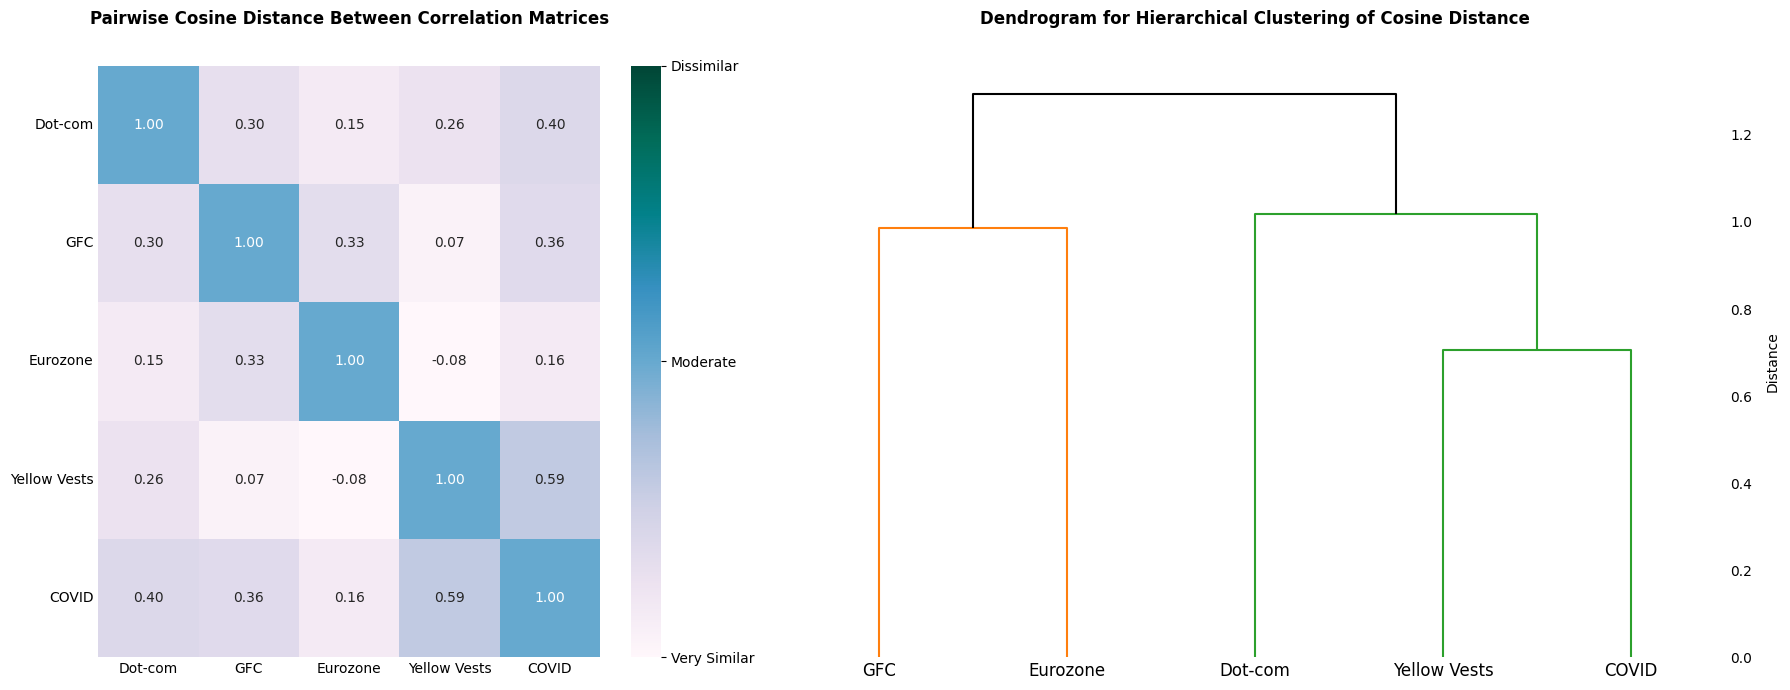

Stress (MDS): 2.623


In [245]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# --- Uzaklık matrisi (cosine distance matrix) varsayalım ---
# cos_dist_matrix = ...

# --- Etiketler ---
labels = ['Dot-com', 'GFC', 'Eurozone', 'Yellow Vests', 'COVID']

# --- Figure Setup ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [4, 6]})

# --- Heatmap ---
sns.heatmap(
    cos_dist_matrix,
    annot=True,
    cmap="PuBuGn",
    xticklabels=labels,
    yticklabels=labels,
    fmt=".2f",
    cbar=True,
    ax=axes[0],
    vmin=0,
    vmax=2
)

# --- Colorbar Labels ---
colorbar = axes[0].collections[0].colorbar
colorbar.set_ticks([0, 1, 2])
colorbar.set_ticklabels(['Very Similar', 'Moderate', 'Dissimilar'])

axes[0].set_title("Pairwise Cosine Distance Between Correlation Matrices", pad=30, fontweight='bold')
axes[0].tick_params(axis='x', bottom=True, labelbottom=True)
axes[0].tick_params(length=0)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# --- Dendrogram ---
Z = linkage(cos_dist_matrix, method='average')  # 'average' uygun, 'ward' sadece ÖKLİD ile çalışır
dendrogram(
    Z,
    labels=labels,
    color_threshold=1.1,
    ax=axes[1],
    above_threshold_color='black'
)
axes[1].set_title("Dendrogram for Hierarchical Clustering of Cosine Distance", pad=30, fontweight='bold')
axes[1].set_ylabel("Distance", labelpad=10)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].tick_params(length=0)

for spine in ['top', 'right', 'left', 'bottom']:
    axes[1].spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

# --- Ekstra: Stress Değeri (MDS ile mesafenin ayrıştırıcılığı) ---
mds = MDS(dissimilarity='precomputed', normalized_stress="auto", random_state=42)
mds.fit(cos_dist_matrix)
print(f"Stress (MDS): {mds.stress_:.3f}")

# --- Opsiyonel: Silhouette Skoru (etiket varsa) ---
# labels_array = [0, 1, 2, 3, 4]  # örnek
# score = silhouette_score(cos_dist_matrix, labels_array, metric="precomputed")
# print(f"Silhouette Score: {score:.3f}")


In [246]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

last = Z[-10:, 2]  # Son birleşmelerin mesafeleri
diffs = last[1:] - last[:-1]  # Aradaki farklar
threshold_suggestion = last[:-1][diffs.argmax()]  # En büyük sıçramanın olduğu yer

print("Suggested threshold:", threshold_suggestion)


Suggested threshold: 0.7059459265004263


In [247]:
diffs

array([0.28103244, 0.03201364, 0.2755208 ])

# **Feature importance analysis**

In [248]:
reg_data = df_stationary.copy()
reg_data

Retail_Volume      CBAR  CPI    LTIR      STIR       IIR  UEMPR
DATE                                                                    
1999-03            0.8 -0.182699 -0.1  0.1990 -0.046704 -0.192800   -0.2
1999-04           -0.4 -0.091516  0.0 -0.1474 -0.350241 -0.216100   -0.1
1999-05            0.7  0.030533 -0.3  0.1793 -0.117503 -0.158100   -0.2
1999-06            0.0  0.137358  0.0  0.3207  0.047730  0.012200   -0.1
1999-07            0.9  0.243858 -0.3  0.3327  0.049773 -0.042300   -0.1
...                ...       ...  ...     ...       ...       ...    ...
2021-08            0.4 -0.517331  0.6 -0.1100 -0.002773 -0.001578    0.0
2021-09            0.0  0.550611 -0.9  0.1600  0.002545 -0.001260   -0.2
2021-10            1.1 -0.501962  0.6  0.1600 -0.004764 -0.001053   -0.2
2021-11            0.2 -0.091726  0.0 -0.1000 -0.017554 -0.002824    0.0
2021-12            0.4 -0.244828 -0.2 -0.0500 -0.014593 -0.003135   -0.1

[274 rows x 7 columns]

# model

In [249]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
reg_data = pd.DataFrame(scaler.fit_transform(reg_data), columns=reg_data.columns, index=reg_data.index)
reg_data

Retail_Volume      CBAR       CPI      LTIR      STIR       IIR  \
DATE                                                                       
1999-03       0.136343 -0.574799 -0.200721  1.354122 -0.234288 -1.340458   
1999-04      -0.193529 -0.284365  0.001476 -0.846125 -2.370495 -1.514633   
1999-05       0.108854  0.104390 -0.605113  1.228992 -0.732551 -1.081063   
1999-06      -0.083572  0.444650  0.001476  2.127130  0.430312  0.191990   
1999-07       0.163833  0.783873 -0.605113  2.203352  0.444690 -0.215417   
...                ...       ...       ...       ...       ...       ...   
2021-08       0.026386 -1.640673  1.214655 -0.608570  0.074888  0.088997   
2021-09      -0.083572  1.760945 -1.818292  1.106404  0.112316  0.091369   
2021-10       0.218811 -1.591721  1.214655  1.106404  0.060873  0.092923   
2021-11      -0.028593 -0.285033  0.001476 -0.545052 -0.029139  0.079678   
2021-12       0.026386 -0.772695 -0.402917 -0.227465 -0.008299  0.077357   

            UEMPR  
DATE               
1999-03 -1.178443  
1999-04 -0.535229  
1999-05 -1.178443  
1999-06 -0.535229  
1999-07 -0.535229  
...           ...  
2021-08  0.107985  
2021-09 -1.178443  
2021-10 -1.178443  
2021-11  0.107985  
2021-12 -0.535229  

[274 rows x 7 columns]

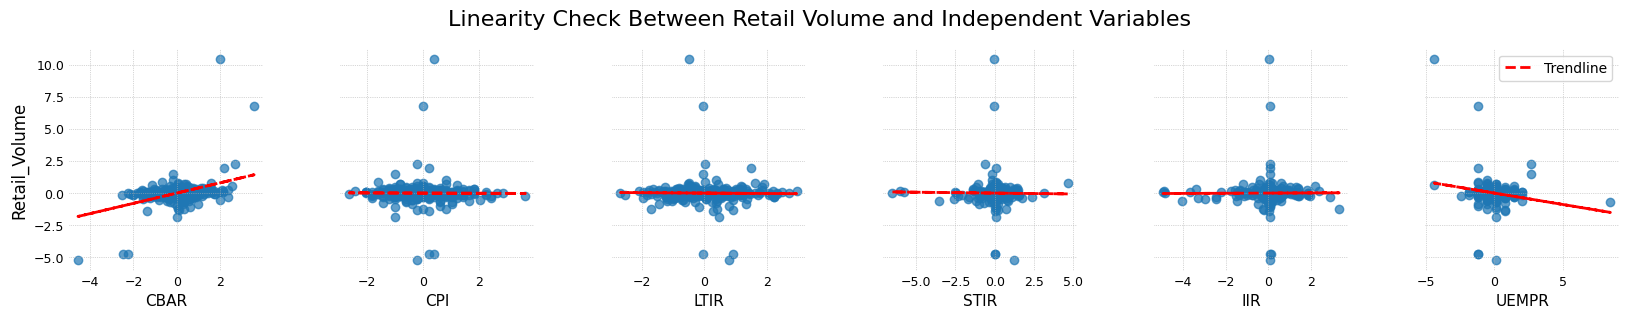

In [250]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, len(reg_data.columns)-1, figsize=(20, 3), sharey=True)
fig.suptitle("Linearity Check Between Retail Volume and Independent Variables", fontsize=16)

axes[0].set_ylabel("Retail_Volume", fontsize=12)

for i, col in enumerate(reg_data.columns):
    if col == "Retail_Volume":
        continue
    ax = axes[i-1]
    x = reg_data[col]
    y = reg_data["Retail_Volume"]
    
    ax.scatter(x, y, alpha=0.7)
    
    # Fit and plot trendline
    coeffs = np.polyfit(x, y, deg=1)
    trend = np.poly1d(coeffs)
    ax.plot(x, trend(x), color='red', linestyle='--', linewidth=2, label='Trendline')
    
    ax.set_xlabel(col, fontsize=11)
    ax.grid(True, linestyle=':', linewidth=0.5)


    # Style adjustments
    ax.tick_params(axis='both', labelsize=9,length=0)
    for spine in ax.spines.values():
        spine.set_visible(False)

ax.legend()

plt.subplots_adjust(top=0.85, wspace=0.4)
plt.show()


### ANOVA

In [251]:
print(reg_data.isnull().sum())

Retail_Volume    0
CBAR             0
CPI              0
LTIR             0
STIR             0
IIR              0
UEMPR            0
dtype: int64


Only CBAR has a correlation

In [252]:
correlation_matrix = reg_data.corr()
print(correlation_matrix['Retail_Volume'])

Retail_Volume    1.000000
CBAR             0.399043
CPI             -0.006936
LTIR            -0.015784
STIR            -0.013810
IIR              0.006527
UEMPR           -0.177729
Name: Retail_Volume, dtype: float64


error interval?
farklı zaman pencerelerinde hesapla ve t teste at

#### multicolinearity

When Ri2 is equal to 0, and therefore, when VIF or tolerance is equal to 1, the ith independent variable is not correlated to the remaining ones, meaning that multicollinearity does not exist.

1. In general terms,
    - VIF equal to 1 = variables are not correlated
    - VIF between 1 and 5 = variables are moderately correlated 
    - VIF greater than 5 = variables are highly correlated

2. The higher the VIF, the higher the possibility that multicollinearity exists, and further research is required. When VIF is higher than 10, there is significant multicollinearity that needs to be corrected.

This output shows the VIF value for each predictor variable, indicating multicollinearity levels in the dataset. The const row represents the intercept term, with a VIF close to 1, meaning it has no multicollinearity. Among the predictor variables, Product_range has the highest VIF (5.94), which suggests that it needs corrective measures. All the other predictors have VIF values below 3, indicating low multicollinearity. 



In [253]:
reg_data.columns

Index(['Retail_Volume', 'CBAR', 'CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR'], dtype='object')

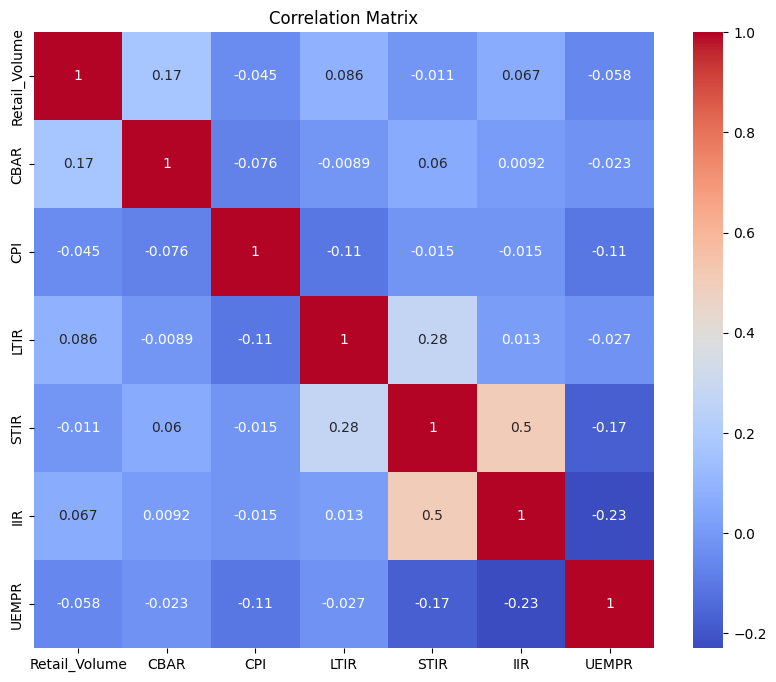

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'housing_df' is the DataFrame containing the data
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(reg_data.corr("spearman"), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [255]:
from sklearn.preprocessing import StandardScaler

selected_features = [ 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR']
X = reg_data[selected_features]
y = reg_data['Retail_Volume']


You will use Standardization to ensure all features are on the same scale, improving model performance and comparability.



In [256]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
import pandas as pd



# Add intercept after scaling
X = add_constant(X)

# Calculate VIF
vif = pd.DataFrame()
vif['Variable'] = ['const'] + selected_features
vif['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif


Variable       VIF
0    const  1.000000
1      CPI  1.022692
2     LTIR  1.106565
3     STIR  2.120563
4      IIR  1.964159
5     CBAR  1.008502
6    UEMPR  1.076371

#### Model

**Mean Squared Error (MSE):** The MSE measures the average squared difference between the predicted and actual values of the target variable. A lower MSE indicates better model performance, as it means the model is making more accurate predictions

**R-squared (R2):**  R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, where 1 is perfect prediction and 0 indicates no linear relationship



#### Homoscedasticity

**Homoscedasticity**: The variance of residuals is constant across all levels of the independent variables. A residual plot can help verify this.

noktalar restgele dağılmalı

#### ANOVA Tests

##### lagged val


In [257]:
# Define lags for each variable as specified
lag_dict = {
    "CPI": [20],
    "UEMPR": [ 2, 3, 6, 7, 11],
    "CBAR": [1, 2, 16, 19]
}

lagged_data = []

for col, lags in lag_dict.items():
    for lag in lags:

        lagged_col = reg_data[col].shift(-lag)
        lagged_col.name = f"{col}_lag{lag}"
        lagged_data.append(lagged_col)

# Combine all lagged columns into a single DataFrame, keeping the index
lagged_df = pd.concat(lagged_data, axis=1)

# Drop rows with any NaN values (due to shifting)
lagged_reg_data = reg_data.join(lagged_df).dropna()

lagged_reg_data

Retail_Volume      CBAR       CPI      LTIR      STIR       IIR  \
DATE                                                                       
1999-03       0.136343 -0.574799 -0.200721  1.354122 -0.234288 -1.340458   
1999-04      -0.193529 -0.284365  0.001476 -0.846125 -2.370495 -1.514633   
1999-05       0.108854  0.104390 -0.605113  1.228992 -0.732551 -1.081063   
1999-06      -0.083572  0.444650  0.001476  2.127130  0.430312  0.191990   
1999-07       0.163833  0.783873 -0.605113  2.203352  0.444690 -0.215417   
...                ...       ...       ...       ...       ...       ...   
2019-12       0.026386 -1.841848  0.810262  0.446456  0.140750  0.092934   
2020-01      -0.001104  0.398667 -2.020489 -0.203328  0.119481  0.121570   
2020-02      -0.193529  0.642593  1.012458 -0.989675 -0.030261  0.094794   
2020-03      -4.729274 -2.480855  0.203672  0.915851  0.039603  0.120189   
2020-04      -5.251571 -4.565505 -0.200721  0.788816  1.238639  0.101988   

            UEMPR  CPI_lag20  UEMPR_lag2  UEMPR_lag3  UEMPR_lag6  UEMPR_lag7  \
DATE                                                                           
1999-03 -1.178443   0.608065   -1.178443   -0.535229   -0.535229   -1.178443   
1999-04 -0.535229  -0.402917   -0.535229   -0.535229   -1.178443   -0.535229   
1999-05 -1.178443  -0.807310   -0.535229   -1.178443   -0.535229   -1.178443   
1999-06 -0.535229   1.416851   -1.178443   -0.535229   -1.178443   -0.535229   
1999-07 -0.535229   0.405869   -0.535229   -1.178443   -0.535229   -1.178443   
...           ...        ...         ...         ...         ...         ...   
2019-12  0.107985   1.214655   -2.464870   -1.178443    2.680840    8.469764   
2020-01  0.107985  -1.818292   -1.178443    0.107985    8.469764    2.680840   
2020-02 -2.464870   1.214655    0.107985   -4.394511    2.680840    0.107985   
2020-03 -1.178443   0.001476   -4.394511    2.680840    0.107985   -4.394511   
2020-04  0.107985  -0.402917    2.680840    8.469764   -4.394511   -1.178443   

         UEMPR_lag11  CBAR_lag1  CBAR_lag2  CBAR_lag16  CBAR_lag19  
DATE                                                                
1999-03    -1.178443  -0.284365   0.104390    0.634316    1.121828  
1999-04    -0.535229   0.104390   0.444650   -1.004013    0.055430  
1999-05    -1.178443   0.444650   0.783873   -1.055537    0.972906  
1999-06    -1.178443   0.783873   0.297703    1.121828    0.344133  
1999-07    -1.178443   0.297703   0.490974    0.055430   -0.714242  
...              ...        ...        ...         ...         ...  
2019-12    -1.178443   0.398667   0.642593    0.007135   -1.392174  
2020-01    -1.178443   0.642593  -2.480855    2.161555   -1.640673  
2020-02     0.751199  -2.480855  -4.565505    2.536162    1.760945  
2020-03     1.394412  -4.565505   2.002506   -1.392174   -1.591721  
2020-04     0.107985   2.002506   2.684117   -1.640673   -0.285033  

[254 rows x 17 columns]

In [258]:
lagged_reg_data.columns

Index(['Retail_Volume', 'CBAR', 'CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR',
       'CPI_lag20', 'UEMPR_lag2', 'UEMPR_lag3', 'UEMPR_lag6', 'UEMPR_lag7',
       'UEMPR_lag11', 'CBAR_lag1', 'CBAR_lag2', 'CBAR_lag16', 'CBAR_lag19'],
      dtype='object')

In [259]:
fromula_lagged = 'Retail_Volume ~ ' + ' + '.join(['CBAR', 'CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR',
       'CPI_lag20', 'UEMPR_lag2', 'UEMPR_lag3', 'UEMPR_lag6', 'UEMPR_lag7',
       'UEMPR_lag11', 'CBAR_lag1', 'CBAR_lag2', 'CBAR_lag16', 'CBAR_lag19'])
fromula_lagged

'Retail_Volume ~ CBAR + CPI + LTIR + STIR + IIR + UEMPR + CPI_lag20 + UEMPR_lag2 + UEMPR_lag3 + UEMPR_lag6 + UEMPR_lag7 + UEMPR_lag11 + CBAR_lag1 + CBAR_lag2 + CBAR_lag16 + CBAR_lag19'

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     8.536
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           3.04e-16
Time:                        09:52:55   Log-Likelihood:                -148.09
No. Observations:                 254   AIC:                             330.2
Df Residuals:                     237   BIC:                             390.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0455      0.028     -1.610      

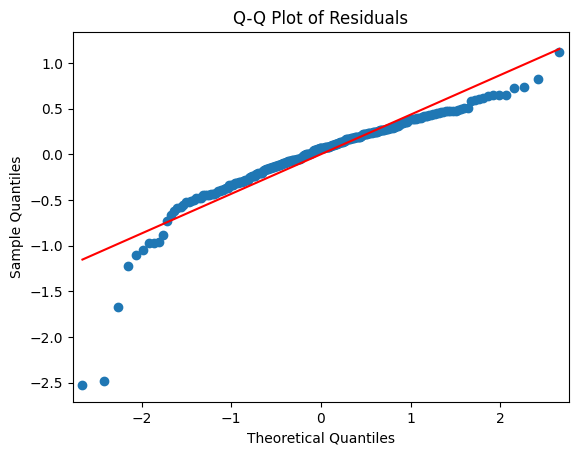

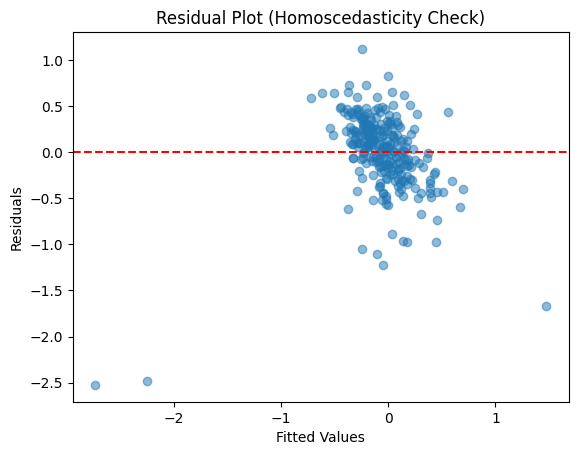

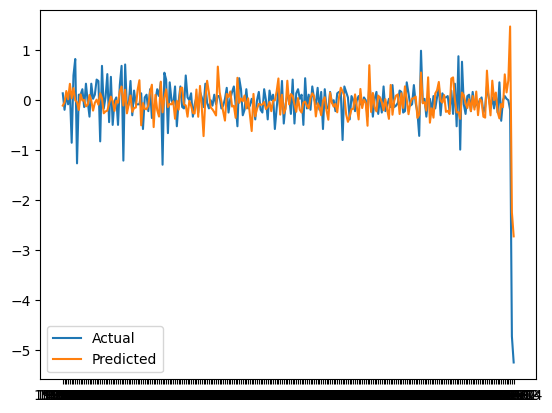

In [260]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Add a constant to the model
model_sm = ols(fromula_lagged, data=lagged_reg_data).fit()
print(model_sm.summary())


# Step 5: Q-Q plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

plt.scatter(model_sm.fittedvalues, model_sm.resid, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Plot only the part of 'Actual' that matches the length of fitted values
plt.plot(lagged_reg_data["Retail_Volume"].iloc[-len(model_sm.fittedvalues):], label='Actual')
plt.plot(model_sm.predict(), label='Predicted')
plt.legend()
plt.show()

In [261]:
import statsmodels.api as sm
# Assume `results` is your RegressionResultsWrapper object
conf_int = model_sm.conf_int(alpha=0.05)  # 95% confidence interval
conf_int.columns = ['0.025', '0.975']    # Rename columns for clarity
conf_int['coefficient'] = model_sm.params  # Add coefficients
conf_int['P>|t|'] = model_sm.pvalues  # Add p-values

# Combine with variable names (index)
summary_df = conf_int[['coefficient', '0.025', '0.975', 'P>|t|']]

# Filter significant coefficients (P>|t| < 0.05)
significant_coef = summary_df[summary_df['P>|t|'] < 0.05]


In [262]:
significant_coef

coefficient     0.025     0.975         P>|t|
CBAR           0.112817  0.048092  0.177542  7.024058e-04
UEMPR_lag2     0.158801  0.075000  0.242602  2.368401e-04
UEMPR_lag3    -0.282135 -0.351930 -0.212341  6.957733e-14

In [263]:
anova_table = sm.stats.anova_lm(model_sm, typ=2)
anova_table = anova_table[anova_table["PR(>F)"] < 0.05].sort_values(by="sum_sq", ascending=False)
anova_table

sum_sq   df          F        PR(>F)
UEMPR_lag3  12.771899  1.0  63.418026  6.957733e-14
UEMPR_lag2   2.806678  1.0  13.936375  2.368401e-04
CBAR         2.374606  1.0  11.790948  7.024058e-04

In [264]:
test_a = significant_coef.index.tolist()
test_a = [feat for feat in test_a if feat != 'Intercept']

test_b = anova_table.sort_values("sum_sq", ascending=False).index.tolist()
# Step 2: Remove 'Residual' if it's present (not a feature)
test_b = [feat for feat in test_b if feat.lower() != 'residual']
test_c = list(set(test_a + test_b))


In [265]:
test_c

['UEMPR_lag2', 'UEMPR_lag3', 'CBAR']

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     39.57
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           5.84e-21
Time:                        09:52:56   Log-Likelihood:                -156.54
No. Observations:                 254   AIC:                             321.1
Df Residuals:                     250   BIC:                             335.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0439      0.028     -1.548      0.1

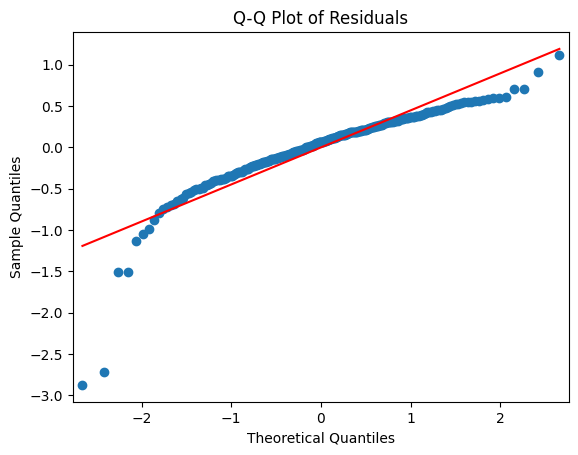

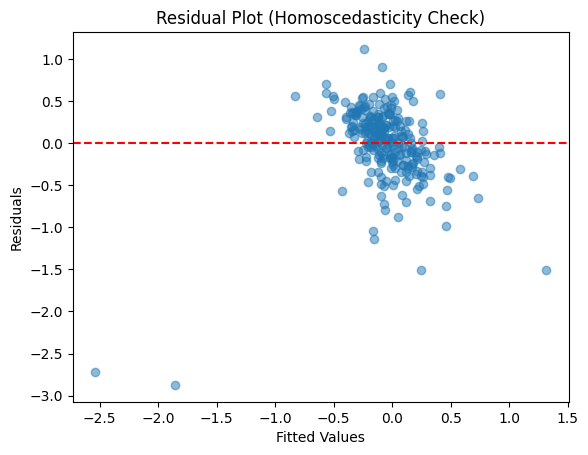

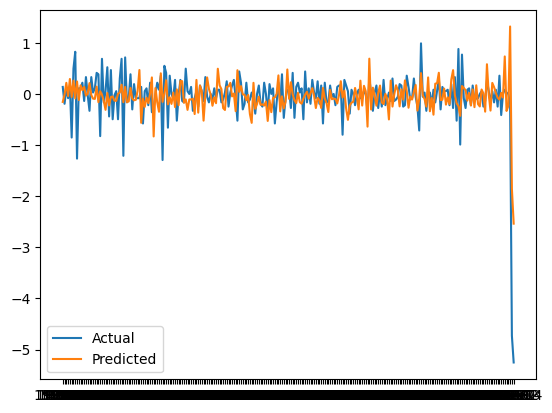

In [266]:
from statsmodels.formula.api import ols
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Step 3: Build formula string
formula = 'Retail_Volume ~ ' + ' + '.join(test_c)

# Step 4: Fit OLS model
model_sm = ols(formula, data=lagged_reg_data).fit()
print(model_sm.summary())

# Step 5: Q-Q plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

plt.scatter(model_sm.fittedvalues, model_sm.resid, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Plot only the part of 'Actual' that matches the length of fitted values
plt.plot(lagged_reg_data["Retail_Volume"].iloc[-len(model_sm.fittedvalues):], label='Actual')
plt.plot(model_sm.fittedvalues, label='Predicted')
plt.legend()
plt.show()

In [267]:
'Retail_Volume ~ ' + ' * '.join(['CBAR', 'CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR', 'UEMPR_lag2', 'UEMPR_lag3'])

'Retail_Volume ~ CBAR * CPI * LTIR * STIR * IIR * UEMPR * UEMPR_lag2 * UEMPR_lag3'

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     4.314
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           1.75e-15
Time:                        09:52:56   Log-Likelihood:                 7.0669
No. Observations:                 254   AIC:                             241.9
Df Residuals:                     126   BIC:                             694.6
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

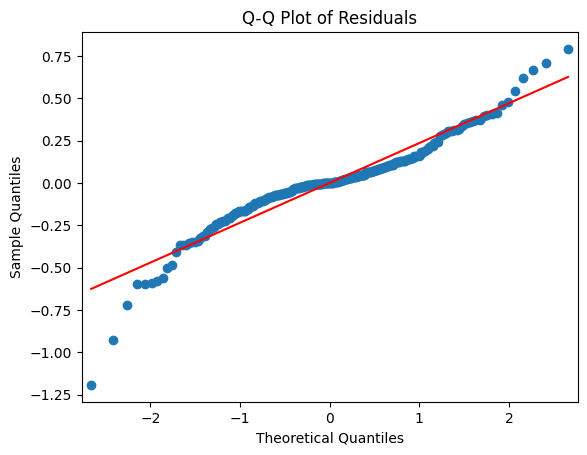

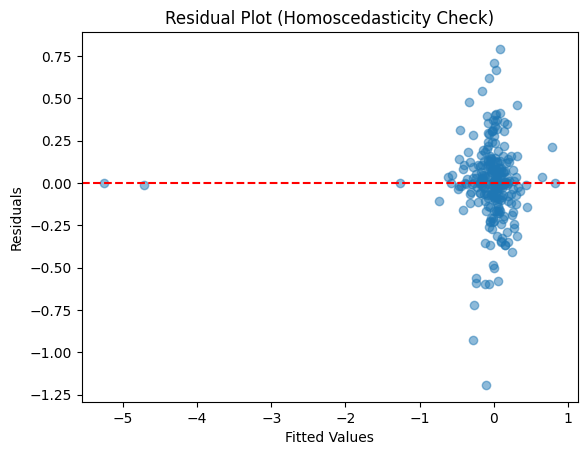

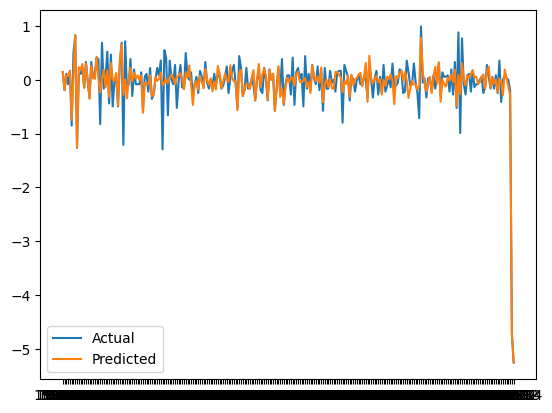

In [268]:

from statsmodels.formula.api import ols
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Step 3: Build formula string
formula = 'Retail_Volume ~ ' + ' * '.join(['CBAR', 'CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR_lag2', 'UEMPR_lag3'])

# Step 4: Fit OLS model
model_sm = ols(formula, data=lagged_reg_data).fit()
print(model_sm.summary())

# Step 5: Q-Q plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

plt.scatter(model_sm.fittedvalues, model_sm.resid, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Plot only the part of 'Actual' that matches the length of fitted values
plt.plot(lagged_reg_data["Retail_Volume"].iloc[-len(model_sm.fittedvalues):], label='Actual')
plt.plot(model_sm.fittedvalues, label='Predicted')
plt.legend()
plt.show()

In [269]:
import statsmodels.api as sm
# Assume `results` is your RegressionResultsWrapper object
conf_int = model_sm.conf_int(alpha=0.05)  # 95% confidence interval
conf_int.columns = ['0.025', '0.975']    # Rename columns for clarity
conf_int['coefficient'] = model_sm.params  # Add coefficients
conf_int['P>|t|'] = model_sm.pvalues  # Add p-values

# Combine with variable names (index)
summary_df = conf_int[['coefficient', '0.025', '0.975', 'P>|t|']]

# Filter significant coefficients (P>|t| < 0.05)
significant_coef = summary_df[summary_df['P>|t|'] < 0.05]

anova_table = sm.stats.anova_lm(model_sm, typ=2)
anova_table = anova_table[anova_table["PR(>F)"] < 0.05].sort_values(by="sum_sq", ascending=False)
anova_table



sum_sq   df          F    PR(>F)
UEMPR_lag2            1.481044  1.0  13.266162  0.000393
UEMPR_lag3            1.098026  1.0   9.835355  0.002131
CBAR:UEMPR_lag3       0.764129  1.0   6.844535  0.009978
CBAR:CPI:UEMPR_lag2   0.626200  1.0   5.609061  0.019388
CBAR:STIR:UEMPR_lag3  0.502991  1.0   4.505446  0.035744

In [270]:
test_a = significant_coef.index.tolist()
test_a = [feat for feat in test_a if feat != 'Intercept']

test_b = anova_table.sort_values("sum_sq", ascending=False).index.tolist()
# Step 2: Remove 'Residual' if it's present (not a feature)
test_b = [feat for feat in test_b if feat.lower() != 'residual']
test_c = list(set(test_a + test_b))

In [271]:
def combined_df(combinations,data):
    # Sütunları oluşturma ve çarpma işlemi
    df = data.copy()
    for comb in combinations:
        columns = comb.split(':')  # ':' ile ayırarak ilgili sütunları al
        product = df[columns[0]]  # ilk sütun ile başla
        for col in columns[1:]:   # geri kalan sütunlarla çarp
            product *= df[col]
        df[comb] = product  # Yeni sütunu DataFrame'e eklw

    return df[combinations]

In [272]:
X = combined_df(test_b,lagged_reg_data)
y = lagged_reg_data['Retail_Volume']

split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

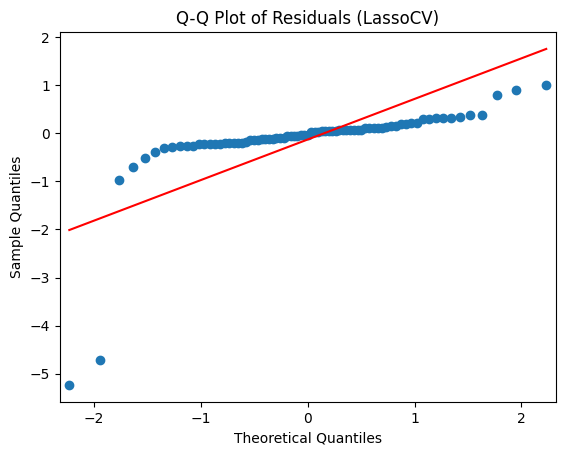

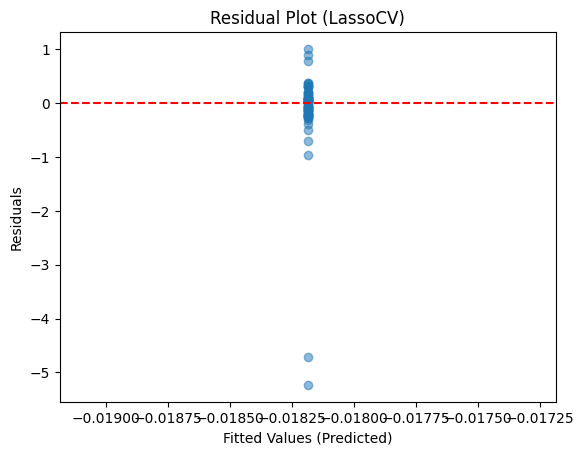

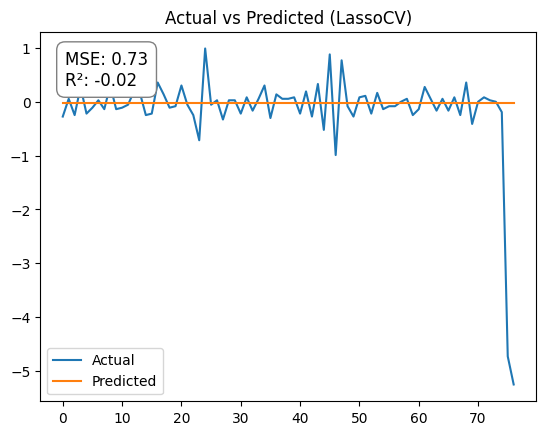

In [273]:
# The 'LinearRegression' model is initialized and fitted to the training data.
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score


lassoregcv = LassoCV(n_alphas=100, random_state=1)
lassoregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred_lasso = lassoregcv.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Residuals
residuals_lasso = y_test - y_pred_lasso

# === Q-Q Plot of Residuals ===
sm.qqplot(residuals_lasso, line='s')
plt.title('Q-Q Plot of Residuals (LassoCV)')
plt.show()

# === Residual Plot (Homoscedasticity Check) ===
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5)
plt.xlabel('Fitted Values (Predicted)')
plt.ylabel('Residuals')
plt.title('Residual Plot (LassoCV)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Optional: Add MSE and R² to the plot
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred_lasso, label='Predicted')
plt.title("Actual vs Predicted (LassoCV)")
plt.legend()
plt.text(0.05, 0.95, f"MSE: {mse_lasso:.2f}\nR²: {r2_lasso:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
plt.show()



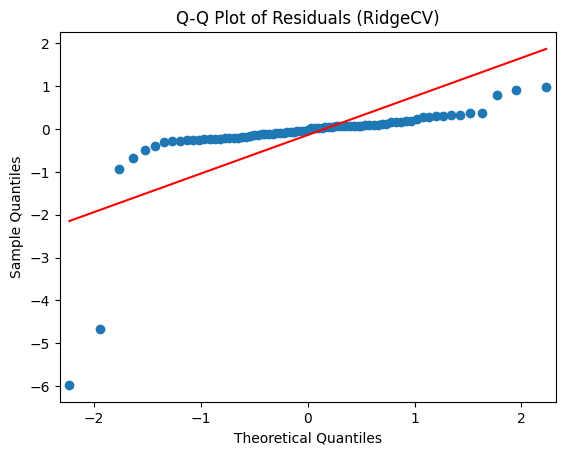

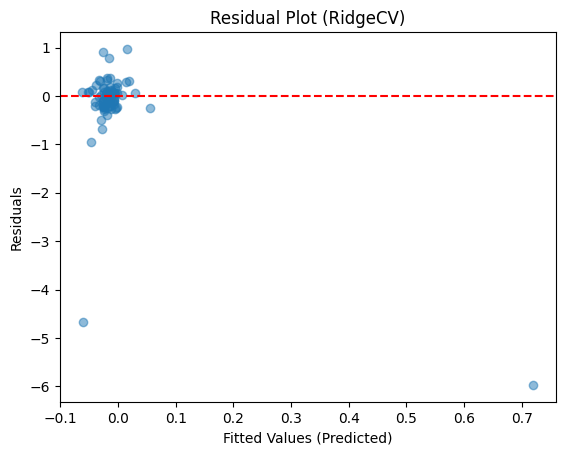

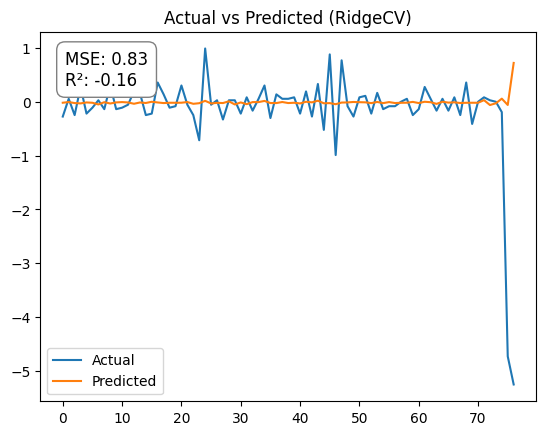

In [274]:
# select the best alpha with RidgeCV
from sklearn.linear_model import RidgeCV

alpha_range = 10.**np.arange(1, 3)
ridgeregcv = RidgeCV(alphas=alpha_range, scoring='neg_mean_squared_error')
ridgeregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred_ridge = ridgeregcv.predict(X_test)


mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Residuals
residuals_ridge = y_test - y_pred_ridge

# === Q-Q Plot of Residuals ===
sm.qqplot(residuals_ridge, line='s')
plt.title('Q-Q Plot of Residuals (RidgeCV)')
plt.show()

# === Residual Plot (Homoscedasticity Check) ===
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5)
plt.xlabel('Fitted Values (Predicted)')
plt.ylabel('Residuals')
plt.title('Residual Plot (RidgeCV)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Optional: Add MSE and R² to the plot
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred_ridge, label='Predicted')
plt.title("Actual vs Predicted (RidgeCV)")
plt.legend()
plt.text(0.05, 0.95, f"MSE: {mse_ridge:.2f}\nR²: {r2_ridge:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
plt.show()



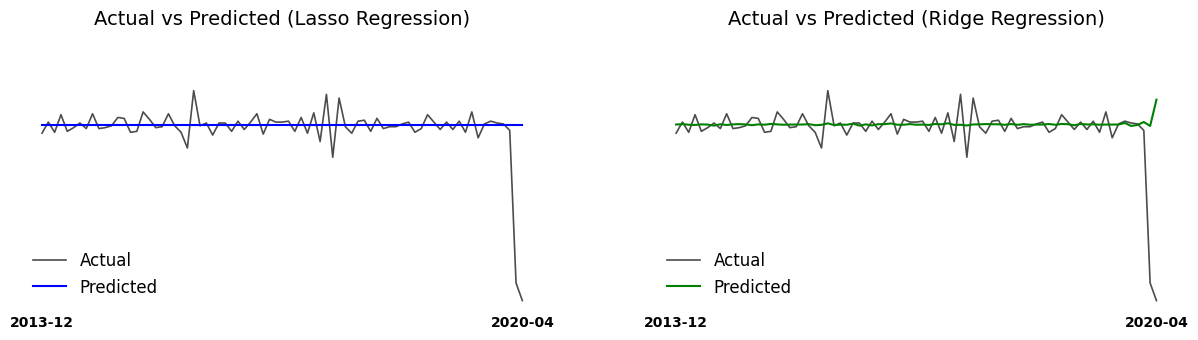

In [275]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharey=True)

# --- Lasso Plot ---
axes[0].plot(y_test, label='Actual', color='black', linewidth=1.2, alpha=0.7)
axes[0].plot(y_pred_lasso, label='Predicted', color='blue', linewidth=1.5)
axes[0].set_title("Actual vs Predicted (Lasso Regression)", fontsize=14,pad=40)
axes[0].set_xticks([0, len(y_test) - 1])
axes[0].set_xticklabels([y_test.index[0], y_test.index[-1]], fontweight='bold', fontsize=10)
axes[0].tick_params(length=0)
for spine in axes[0].spines.values():
    spine.set_visible(False)
axes[0].grid(False)
axes[0].legend(frameon=False, fontsize=12)

# --- Ridge Plot ---
axes[1].plot(y_test, label='Actual', color='black', linewidth=1.2,alpha=0.7)
axes[1].plot(y_pred_ridge, label='Predicted', color='green', linewidth=1.5)
axes[1].set_title("Actual vs Predicted (Ridge Regression)", fontsize=14,pad=40)
axes[1].set_xticks([0, len(y_test) - 1])
axes[1].set_xticklabels([y_test.index[0], y_test.index[-1]], fontweight='bold', fontsize=10)
axes[1].set_yticks([])
axes[1].tick_params(length=0)
for spine in axes[1].spines.values():
    spine.set_visible(False)
axes[1].grid(False)
axes[1].legend(frameon=False, fontsize=12)

# Adjust layout and add padding to top
plt.show()

##### normal val

In [276]:
X = reg_data[['CBAR', 'CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR']]
y = reg_data['Retail_Volume']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     3.705
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           6.92e-13
Time:                        09:52:57   Log-Likelihood:                -286.39
No. Observations:                 274   AIC:                             700.8
Df Residuals:                     210   BIC:                             932.0
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

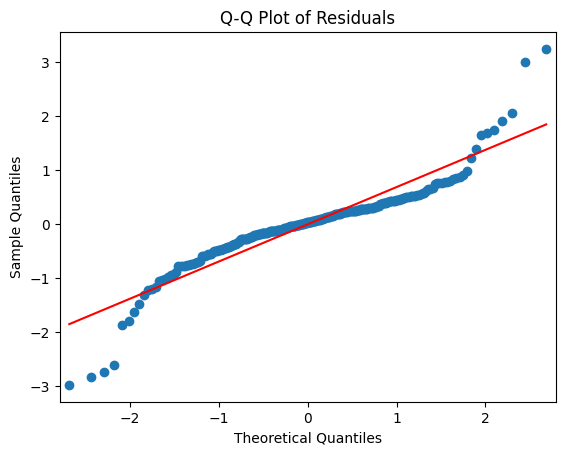

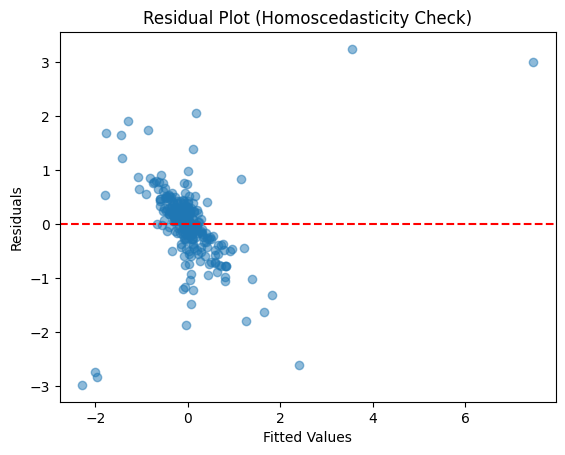

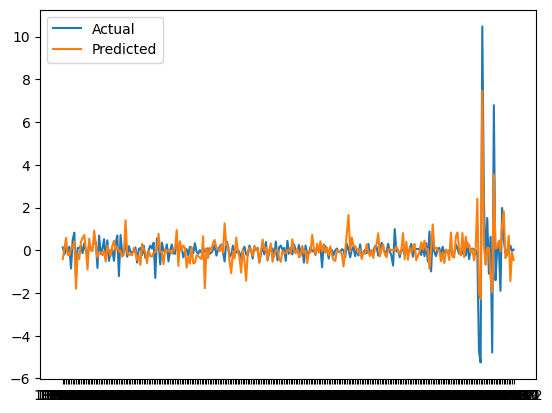

In [277]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Add a constant to the model
model_sm = ols('Retail_Volume ~ CPI* LTIR * STIR * IIR * CBAR * UEMPR ', data=reg_data).fit()
print(model_sm.summary())


# Step 5: Q-Q plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

plt.scatter(model_sm.fittedvalues, model_sm.resid, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Plot only the part of 'Actual' that matches the length of fitted values
plt.plot(reg_data["Retail_Volume"].iloc[-len(model_sm.fittedvalues):], label='Actual')
plt.plot(model_sm.predict(), label='Predicted')
plt.legend()
plt.show()

In [278]:
import statsmodels.api as sm
# Assume `results` is your RegressionResultsWrapper object
conf_int = model_sm.conf_int(alpha=0.05)  # 95% confidence interval
conf_int.columns = ['0.025', '0.975']    # Rename columns for clarity
conf_int['coefficient'] = model_sm.params  # Add coefficients
conf_int['P>|t|'] = model_sm.pvalues  # Add p-values

# Combine with variable names (index)
summary_df = conf_int[['coefficient', '0.025', '0.975', 'P>|t|']]

# Filter significant coefficients (P>|t| < 0.05)
significant_coef = summary_df[summary_df['P>|t|'] < 0.05]


In [279]:
significant_coef

coefficient     0.025     0.975         P>|t|
CBAR                     0.291939  0.166245  0.417633  8.011866e-06
LTIR:STIR:IIR:CBAR       0.454236  0.044806  0.863665  2.984257e-02
UEMPR                   -0.193148 -0.327569 -0.058726  5.067426e-03
LTIR:UEMPR               0.219282  0.044011  0.394553  1.445174e-02
STIR:UEMPR              -0.465483 -0.777178 -0.153788  3.605130e-03
LTIR:STIR:UEMPR          0.366672  0.010879  0.722465  4.345375e-02
IIR:UEMPR                0.393720  0.104595  0.682844  7.843987e-03
CBAR:UEMPR              -0.634728 -0.770137 -0.499319  2.796798e-17
LTIR:CBAR:UEMPR          0.183424  0.003182  0.363665  4.612539e-02
STIR:CBAR:UEMPR         -0.789182 -1.152131 -0.426233  2.766786e-05
LTIR:STIR:CBAR:UEMPR     1.011906  0.406583  1.617229  1.153581e-03
IIR:CBAR:UEMPR           0.561637  0.158327  0.964947  6.571395e-03

In [280]:
anova_table = sm.stats.anova_lm(model_sm, typ=2)
anova_table = anova_table[anova_table["PR(>F)"] < 0.05].sort_values(by="sum_sq", ascending=False)
anova_table

sum_sq   df          F        PR(>F)
CBAR                  45.087214  1.0  72.966223  2.690315e-15
CBAR:UEMPR            43.143258  1.0  69.820250  8.841370e-15
STIR:CBAR:UEMPR       11.568826  1.0  18.722238  2.338236e-05
UEMPR                  9.098763  1.0  14.724848  1.645554e-04
LTIR:STIR:CBAR:UEMPR   6.463623  1.0  10.460308  1.416682e-03
STIR:UEMPR             5.164823  1.0   8.358414  4.242648e-03
IIR:CBAR:UEMPR         4.977654  1.0   8.055513  4.981587e-03
LTIR:UEMPR             4.633461  1.0   7.498492  6.705337e-03
LTIR:CBAR:UEMPR        4.320713  1.0   6.992362  8.804014e-03
LTIR:STIR:IIR:CBAR     4.139020  1.0   6.698321  1.032426e-02
CPI:UEMPR              2.498358  1.0   4.043181  4.562889e-02

In [281]:
test_a = significant_coef.index.tolist()
test_a


['CBAR',
 'LTIR:STIR:IIR:CBAR',
 'UEMPR',
 'LTIR:UEMPR',
 'STIR:UEMPR',
 'LTIR:STIR:UEMPR',
 'IIR:UEMPR',
 'CBAR:UEMPR',
 'LTIR:CBAR:UEMPR',
 'STIR:CBAR:UEMPR',
 'LTIR:STIR:CBAR:UEMPR',
 'IIR:CBAR:UEMPR']

In [282]:
# Step 1: Sort ANOVA table and get top 30 features
test_b = anova_table.sort_values("sum_sq", ascending=False).index.tolist()
# Step 2: Remove 'Residual' if it's present (not a feature)
test_b = [feat for feat in test_b if feat.lower() != 'residual']
test_b

['CBAR',
 'CBAR:UEMPR',
 'STIR:CBAR:UEMPR',
 'UEMPR',
 'LTIR:STIR:CBAR:UEMPR',
 'STIR:UEMPR',
 'IIR:CBAR:UEMPR',
 'LTIR:UEMPR',
 'LTIR:CBAR:UEMPR',
 'LTIR:STIR:IIR:CBAR',
 'CPI:UEMPR']

In [283]:
test_c = list(set(test_a + test_b))
test_c

['STIR:UEMPR',
 'UEMPR',
 'IIR:CBAR:UEMPR',
 'LTIR:UEMPR',
 'LTIR:STIR:CBAR:UEMPR',
 'CBAR',
 'IIR:UEMPR',
 'LTIR:STIR:UEMPR',
 'LTIR:CBAR:UEMPR',
 'CBAR:UEMPR',
 'CPI:UEMPR',
 'LTIR:STIR:IIR:CBAR',
 'STIR:CBAR:UEMPR']

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     15.76
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           3.01e-26
Time:                        09:52:58   Log-Likelihood:                -309.16
No. Observations:                 274   AIC:                             646.3
Df Residuals:                     260   BIC:                             696.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0153 

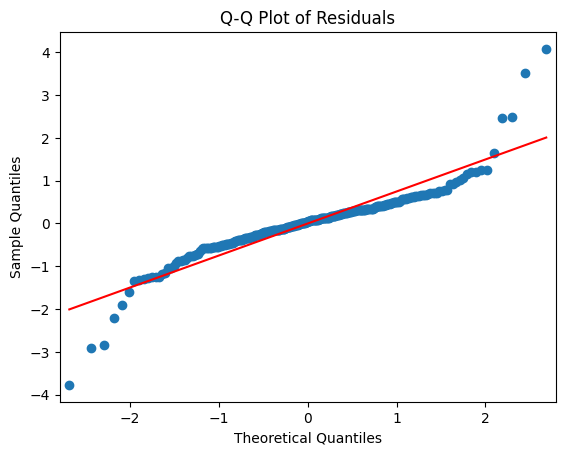

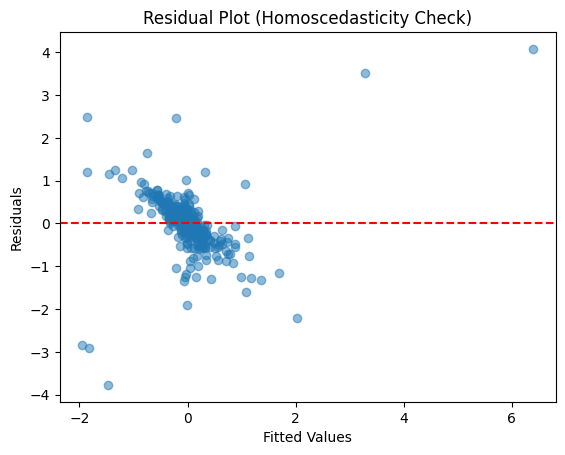

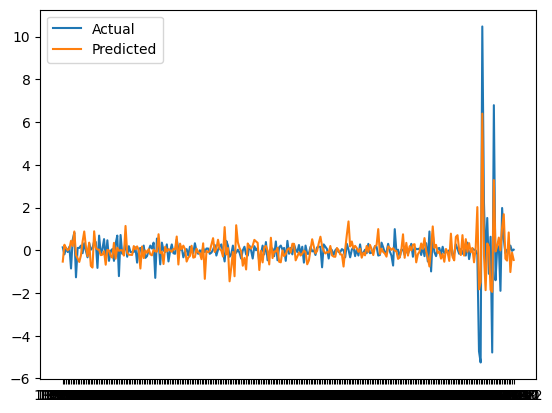

In [284]:
from statsmodels.formula.api import ols
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Step 3: Build formula string
formula = 'Retail_Volume ~ ' + ' + '.join(test_c)

# Step 4: Fit OLS model
model_sm = ols(formula, data=reg_data).fit()
print(model_sm.summary())

# Step 5: Q-Q plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

plt.scatter(model_sm.fittedvalues, model_sm.resid, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Plot only the part of 'Actual' that matches the length of fitted values
plt.plot(reg_data["Retail_Volume"].iloc[-len(model_sm.fittedvalues):], label='Actual')
plt.plot(model_sm.fittedvalues, label='Predicted')
plt.legend()
plt.show()

In [285]:
combined_df(test_a,reg_data)

CBAR  LTIR:STIR:IIR:CBAR     UEMPR  LTIR:UEMPR  STIR:UEMPR  \
DATE                                                                      
1999-03  0.677368           -0.244442 -1.178443    0.288061    0.276095   
1999-04  0.152200            0.863887 -0.535229   -0.462377    1.268757   
1999-05 -0.123018            0.101601 -1.178443   -0.119731    0.863269   
1999-06 -0.237990            0.078140 -0.535229   -0.041823   -0.230315   
1999-07 -0.419552           -0.165450 -0.535229    0.088554   -0.238011   
...           ...                 ...       ...         ...         ...   
2021-08 -0.177168            0.006655  0.107985    0.000719    0.008087   
2021-09 -2.075173            0.019994 -1.178443   -0.023562   -0.132358   
2021-10  1.875752           -0.009962 -1.178443    0.011739   -0.071736   
2021-11 -0.030779           -0.000361  0.107985   -0.000039   -0.003147   
2021-12  0.413569           -0.000113 -0.535229    0.000060    0.004442   

         LTIR:STIR:UEMPR  IIR:UEMPR  CBAR:UEMPR  LTIR:CBAR:UEMPR  \
DATE                                                               
1999-03    -9.372400e-02   1.579652    0.677368     7.481414e-02   
1999-04     3.139892e-01   0.810676    0.152200    -2.557818e-02   
1999-05     1.218035e-01   1.273971   -0.123018     1.765776e-02   
1999-06    -5.155586e-03  -0.102759   -0.237990    -6.567132e-04   
1999-07     1.128087e-02   0.115297   -0.419552     2.533190e-03   
...                  ...        ...         ...              ...   
2021-08     6.275172e-07   0.009610   -0.177168    -1.200530e-08   
2021-09    -3.675111e-03  -0.107673   -2.075173    -8.987384e-03   
2021-10     9.924003e-04  -0.109505    1.875752    -2.193668e-03   
2021-11     1.323439e-08   0.008604   -0.030779    -4.398701e-11   
2021-12    -1.435731e-07  -0.041404    0.413569     3.178046e-08   

         STIR:CBAR:UEMPR  LTIR:STIR:CBAR:UEMPR  IIR:CBAR:UEMPR  
DATE                                                            
1999-03        -0.220389          1.316155e-02       -1.260940  
1999-04        -0.103355         -2.153565e-04       -0.066039  
1999-05         0.125147          3.203565e-04        0.184686  
1999-06        -0.029337          2.454112e-06       -0.013089  
1999-07        -0.053447         -3.040291e-05        0.025891  
...                  ...                   ...             ...  
2021-08        -0.000155         -3.553403e-14       -0.000184  
2021-09        -0.323679          7.113945e-03       -0.263312  
2021-10         0.158570          7.689103e-04        0.242057  
2021-11         0.000010          1.528978e-18       -0.000029  
2021-12        -0.000983          6.916552e-12        0.009165  

[274 rows x 12 columns]

In [286]:
X = combined_df(test_a,reg_data)
y = reg_data['Retail_Volume']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]



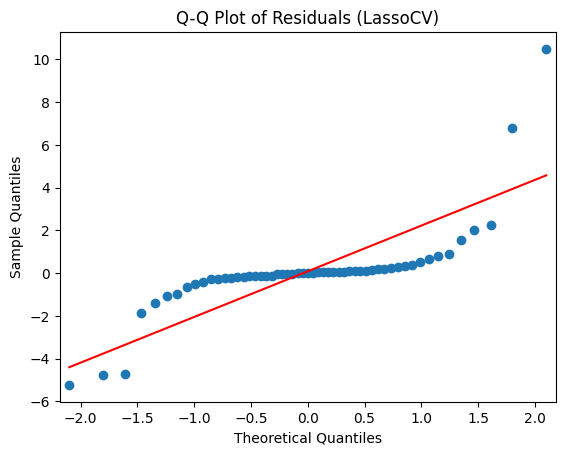

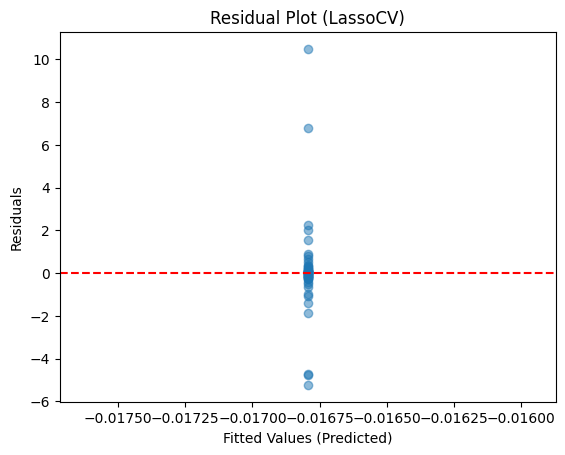

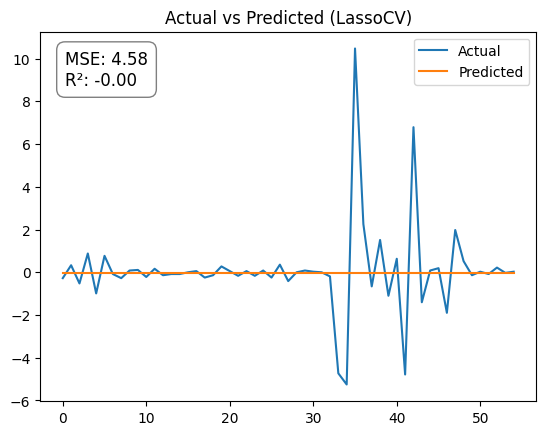

In [287]:
# The 'LinearRegression' model is initialized and fitted to the training data.
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score


lassoregcv = LassoCV(n_alphas=100, random_state=1)
lassoregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred_lasso = lassoregcv.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Residuals
residuals_lasso = y_test - y_pred_lasso

# === Q-Q Plot of Residuals ===
sm.qqplot(residuals_lasso, line='s')
plt.title('Q-Q Plot of Residuals (LassoCV)')
plt.show()

# === Residual Plot (Homoscedasticity Check) ===
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5)
plt.xlabel('Fitted Values (Predicted)')
plt.ylabel('Residuals')
plt.title('Residual Plot (LassoCV)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Optional: Add MSE and R² to the plot
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred_lasso, label='Predicted')
plt.title("Actual vs Predicted (LassoCV)")
plt.legend()
plt.text(0.05, 0.95, f"MSE: {mse_lasso:.2f}\nR²: {r2_lasso:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
plt.show()



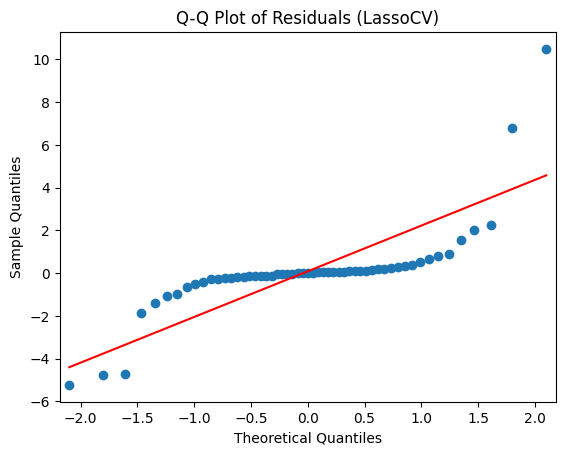

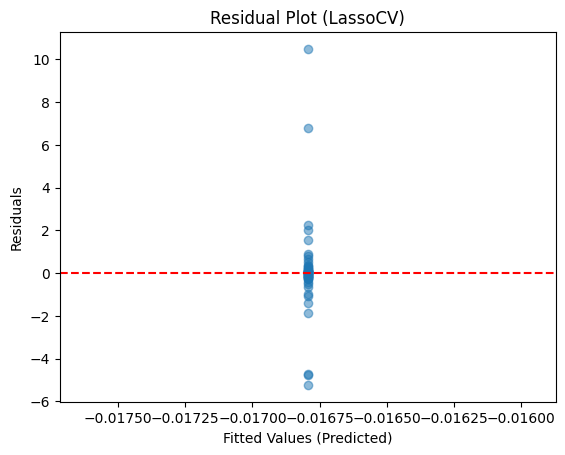

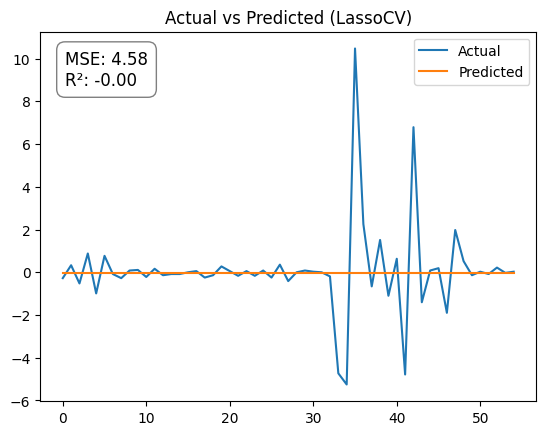

In [288]:
# The 'LinearRegression' model is initialized and fitted to the training data.
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score


lassoregcv = LassoCV(n_alphas=100, random_state=1)
lassoregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred_lasso = lassoregcv.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Residuals
residuals_lasso = y_test - y_pred_lasso

# === Q-Q Plot of Residuals ===
sm.qqplot(residuals_lasso, line='s')
plt.title('Q-Q Plot of Residuals (LassoCV)')
plt.show()

# === Residual Plot (Homoscedasticity Check) ===
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5)
plt.xlabel('Fitted Values (Predicted)')
plt.ylabel('Residuals')
plt.title('Residual Plot (LassoCV)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Optional: Add MSE and R² to the plot
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred_lasso, label='Predicted')
plt.title("Actual vs Predicted (LassoCV)")
plt.legend()
plt.text(0.05, 0.95, f"MSE: {mse_lasso:.2f}\nR²: {r2_lasso:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
plt.show()



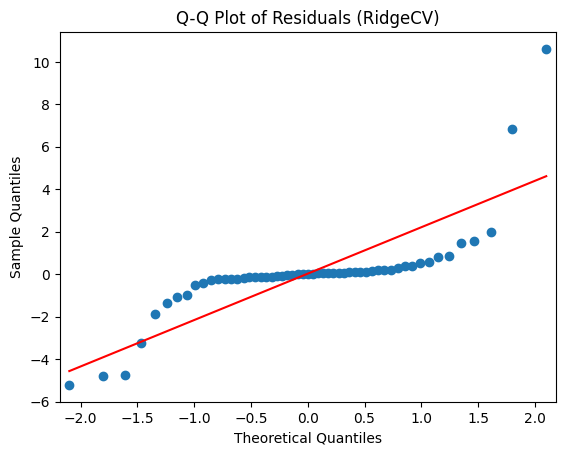

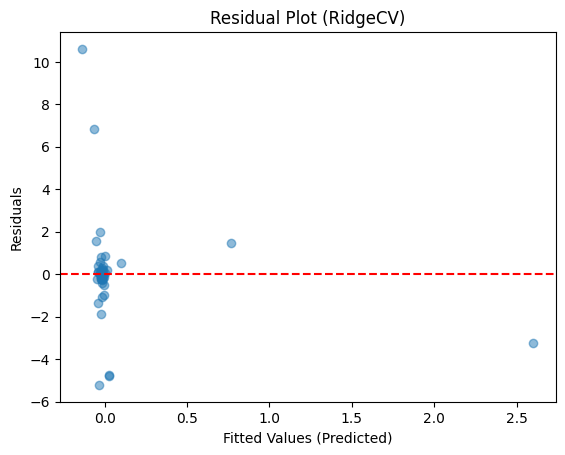

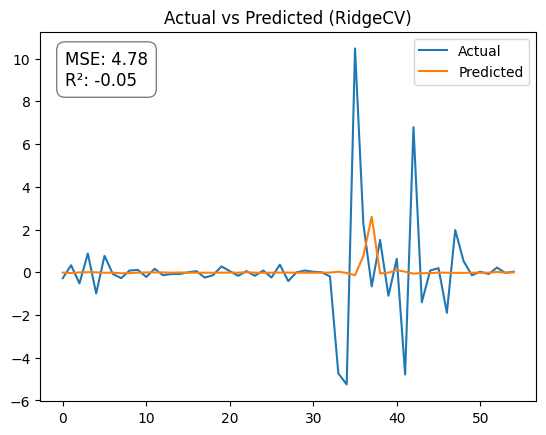

In [289]:
# select the best alpha with RidgeCV
from sklearn.linear_model import RidgeCV

alpha_range = 10.**np.arange(1, 3)
ridgeregcv = RidgeCV(alphas=alpha_range, scoring='neg_mean_squared_error')
ridgeregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred_ridge = ridgeregcv.predict(X_test)


mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Residuals
residuals_ridge = y_test - y_pred_ridge

# === Q-Q Plot of Residuals ===
sm.qqplot(residuals_ridge, line='s')
plt.title('Q-Q Plot of Residuals (RidgeCV)')
plt.show()

# === Residual Plot (Homoscedasticity Check) ===
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5)
plt.xlabel('Fitted Values (Predicted)')
plt.ylabel('Residuals')
plt.title('Residual Plot (RidgeCV)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Optional: Add MSE and R² to the plot
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred_ridge, label='Predicted')
plt.title("Actual vs Predicted (RidgeCV)")
plt.legend()
plt.text(0.05, 0.95, f"MSE: {mse_ridge:.2f}\nR²: {r2_ridge:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
plt.show()



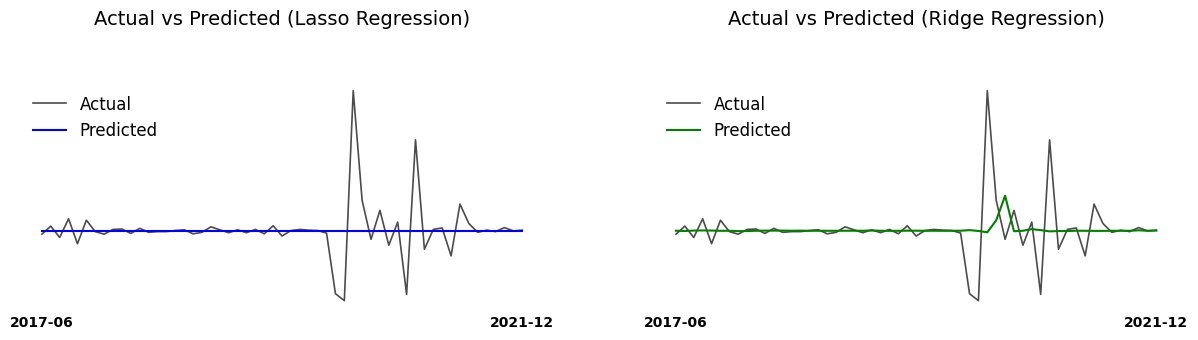

In [290]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharey=True)

# --- Lasso Plot ---
axes[0].plot(y_test, label='Actual', color='black', linewidth=1.2, alpha=0.7)
axes[0].plot(y_pred_lasso, label='Predicted', color='blue', linewidth=1.5)
axes[0].set_title("Actual vs Predicted (Lasso Regression)", fontsize=14,pad=40)
axes[0].set_xticks([0, len(y_test) - 1])
axes[0].set_xticklabels([y_test.index[0], y_test.index[-1]], fontweight='bold', fontsize=10)
axes[0].tick_params(length=0)
for spine in axes[0].spines.values():
    spine.set_visible(False)
axes[0].grid(False)
axes[0].legend(frameon=False, fontsize=12)

# --- Ridge Plot ---
axes[1].plot(y_test, label='Actual', color='black', linewidth=1.2,alpha=0.7)
axes[1].plot(y_pred_ridge, label='Predicted', color='green', linewidth=1.5)
axes[1].set_title("Actual vs Predicted (Ridge Regression)", fontsize=14,pad=40)
axes[1].set_xticks([0, len(y_test) - 1])
axes[1].set_xticklabels([y_test.index[0], y_test.index[-1]], fontweight='bold', fontsize=10)
axes[1].set_yticks([])
axes[1].tick_params(length=0)
for spine in axes[1].spines.values():
    spine.set_visible(False)
axes[1].grid(False)
axes[1].legend(frameon=False, fontsize=12)

# Adjust layout and add padding to top
plt.show()

### Permutation importance

In [291]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)


result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)


importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)


                 feature  importance_mean  importance_std
5        LTIR:STIR:UEMPR       227.062074       16.952204
8        LTIR:CBAR:UEMPR       123.519276        8.852621
3             LTIR:UEMPR        68.147388        6.136366
1     LTIR:STIR:IIR:CBAR         3.676679        0.687741
4             STIR:UEMPR         0.569614        0.113653
9        STIR:CBAR:UEMPR         0.063117        0.950352
2                  UEMPR        -0.034287        0.018130
6              IIR:UEMPR        -0.486622        0.121872
0                   CBAR        -1.089697        0.420429
7             CBAR:UEMPR        -1.089697        0.420429
11        IIR:CBAR:UEMPR        -2.270505        1.677839
10  LTIR:STIR:CBAR:UEMPR        -3.127210        3.097540


In [292]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

# **Causality**

In [293]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

def plot_granger_causality_pvalues(df, maxlag, variables, alpha=0.05, verbose=False):
    """
    Run grangercausalitytests and plot p-values for each lag.

    Parameters:
    - df: DataFrame with two columns [Y, X] where X is tested as a cause of Y
    - maxlag: maximum lag to test
    - variables: tuple (Y, X) – names of the dependent and independent variables
    - alpha: significance level for rejection
    - verbose: if True, prints full test output
    """
    y_col, x_col = variables
    test_result = grangercausalitytests(df[[y_col, x_col]], maxlag=maxlag, verbose=verbose)

    p_values = []
    for lag in range(1, maxlag + 1):
        p_val = test_result[lag][0]['ssr_ftest'][1]  # extract p-value from F-test
        p_values.append(p_val)

    # Plot p-values
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, maxlag + 1), p_values, color='skyblue')
    plt.axhline(y=alpha, color='red', linestyle='--', label=f'Significance level ({alpha})')
    plt.xticks(range(1, maxlag + 1))
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.title(f"Granger Causality Test p-values: Does {x_col} → {y_col}?")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return p_values


/Users/emirysaglam/GitHub/Bitirme2/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


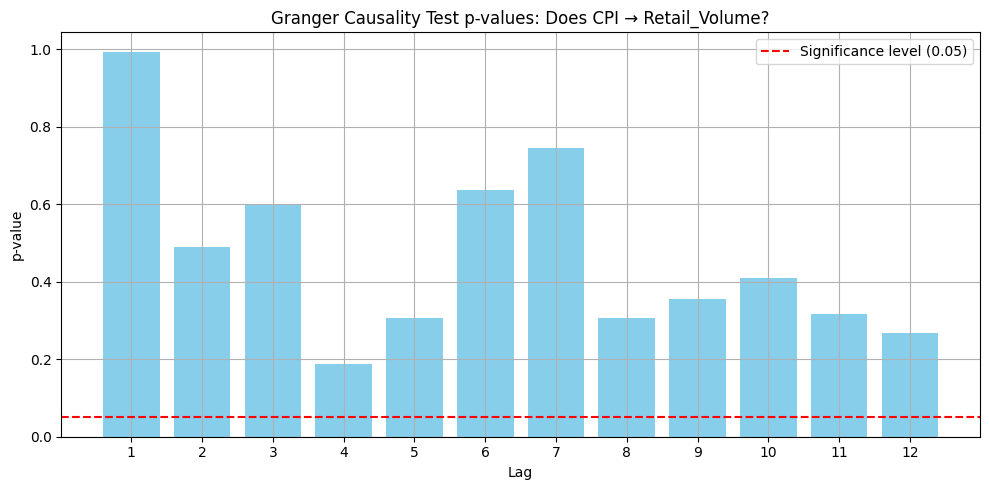

[np.float64(0.9935707818003926),
 np.float64(0.4903296815799947),
 np.float64(0.5981655134076276),
 np.float64(0.18786578516777125),
 np.float64(0.30634869668452425),
 np.float64(0.6362399508304495),
 np.float64(0.7460788684520772),
 np.float64(0.3067961086329045),
 np.float64(0.35560470982300485),
 np.float64(0.40988763184383953),
 np.float64(0.31642538940355097),
 np.float64(0.26631823038784685)]

In [294]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

plot_granger_causality_pvalues(df_test, 12, variables=('Retail_Volume','CPI'))


# **Cointegration**

In [295]:
from statsmodels.tsa.stattools import coint

# Two time series: y and x (non-stationary)
# For example: y = GDP, x = Unemployment Rate
score, pvalue, _ = coint(df_test["Retail_Volume"],df_test["CBAR"])

print("Cointegration Test p-value:", pvalue)

if pvalue < 0.05:
    print("✅ Series are cointegrated.")
else:
    print("❌ No cointegration detected.")


Cointegration Test p-value: 1.03993061540743e-09
✅ Series are cointegrated.


In [296]:
con.close()